# Project

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
pd.options.mode.chained_assignment = None  # default='warn'
from folium import plugins
from folium.plugins import HeatMap
from sklearn.metrics import confusion_matrix
import numpy as np
np.random.seed(42)
import joblib
from bokeh.models import ColumnDataSource, Legend
from bokeh.plotting import figure, show, output_notebook
from bokeh.plotting import figure
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc
from bokeh.layouts import layout
from bokeh.models import ColumnDataSource, Legend, HoverTool, LegendItem
from bokeh.io import show, output_file, output_notebook
import numpy as np
np.random.seed(42)

#### Data Sources:

Microclimate Sensor Readings in Melbourne: https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Readings/u4vh-84j8 

Microclimate Sensor Locations in Melbourne: https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Locations/irqv-hjr4

Pedestrian Counting Sensor Readings: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp 

Pedestrian Counting Sensor Locations: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234 

Let's inspect the column features of the microclimate sensor readings:

In [2]:
df_reading = pd.read_csv("Microclimate_Sensor_Readings.csv")
# df_reading["type"].unique()
# df_reading.head()
df_reading["type"].unique()

array(['PM2.5-EPA-1h', 'PM2.5-EPA-1h-NOPK', 'PM2.5-EPA-1h-NOPK-EPA-24h',
       'PM2.5-EPA-1h-PKIND', 'PM2.5-EPA-24h', 'PM10-EPA-1h',
       'PM10-EPA-1h-NOPK', 'PM10-EPA-1h-NOPK-EPA-24h',
       'PM10-EPA-1h-PKIND', 'PM10-EPA-24h', 'TPH.TEMP-EPA-1h',
       'TPH.RH-EPA-1h', 'TPH.RH', 'TPH.TEMP', 'TPH.PRESSURE', 'WS',
       'PM2.5', 'PM10'], dtype=object)

As we inspected each type, we found out from the data source webpage that the 'NOPL' value refers to values without erroneous readings. So we will keep only those.

In [3]:
# keep only the values of interest: without erroneous readings. Hourly/Daily averages preffered over simple measurements
df_reading = df_reading.loc[df_reading['type'].isin(['PM2.5-EPA-1h-NOPK', 'PM2.5-EPA-1h-NOPK-EPA-24h', 'PM10-EPA-1h-NOPK', 'PM10-EPA-1h-NOPK-EPA-24h', 'TPH.TEMP-EPA-1h', 'TPH.RH-EPA-1h', 'TPH.PRESSURE', 'WS'])]
df_reading.reset_index(inplace=True)
df_reading.type.unique()

array(['PM2.5-EPA-1h-NOPK', 'PM2.5-EPA-1h-NOPK-EPA-24h',
       'PM10-EPA-1h-NOPK', 'PM10-EPA-1h-NOPK-EPA-24h', 'TPH.TEMP-EPA-1h',
       'TPH.RH-EPA-1h', 'TPH.PRESSURE', 'WS'], dtype=object)

In [4]:
print("We have {} clean readings without errors".format(len(df_reading)))

We have 1404040 clean readings without errors


In [5]:
df_reading['measure'] = df_reading['type'] 
df_reading['measure'] = df_reading.loc[:, 'type']
df_reading['frequency'] = df_reading['measure'] 
df_reading['frequency'] = df_reading.loc[:, 'measure']

In [6]:
df_reading["measure"].replace({"PM2.5-EPA-1h-NOPK": "Particulate Air Pollution (2.5 µm)", 
                               "PM2.5-EPA-1h-NOPK-EPA-24h": "Particulate Air Pollution (2.5 µm)",
                               "PM10-EPA-1h-NOPK": "Particulate Air Pollution (10 µm)", 
                               "PM10-EPA-1h-NOPK-EPA-24h": "Particulate Air Pollution (10 µm)",
                               "TPH.TEMP-EPA-1h": "Ambient Air Temperature", 
                               "TPH.RH-EPA-1h": "Relative Humidity",
                               "TPH.PRESSURE": "Barometric Pressure", 
                               "WS": "Average Wind Speed "}, inplace=True)

In [7]:
df_reading["frequency"].replace({"PM2.5-EPA-1h-NOPK": "hourly", 
                               "PM2.5-EPA-1h-NOPK-EPA-24h": "daily",
                               "PM10-EPA-1h-NOPK": "hourly", 
                               "PM10-EPA-1h-NOPK-EPA-24h": "daily",
                               "TPH.TEMP-EPA-1h": "hourly", 
                               "TPH.RH-EPA-1h": "hourly",
                               "TPH.PRESSURE": "unknown", 
                               "WS": "unknown"}, inplace=True)

In [8]:
# make an extra column by extracting the day of the week of the given Date column:
df_reading['Date']  = pd.to_datetime(df_reading['local_time'], infer_datetime_format=True)
df_reading.drop(['local_time'], axis=1, inplace=True)

In [9]:
df_reading.head(100)

,index,id,site_id,gateway_hub_id,sensor_id,value,type,units,measure,frequency,Date
0,1,2,1001,arc1045,0a.EPA-1h.NOPK,3.90,PM2.5-EPA-1h-NOPK,ug/m^3,Particulate Air Pollution (2.5 µm),hourly,2019-11-15 09:00:00
1,2,3,1001,arc1045,0a.EPA-1h.NOPK.EPA-24h,5.50,PM2.5-EPA-1h-NOPK-EPA-24h,ug/m^3,Particulate Air Pollution (2.5 µm),daily,2019-11-15 09:00:00
2,6,7,1001,arc1045,0b.EPA-1h.NOPK,19.50,PM10-EPA-1h-NOPK,ug/m^3,Particulate Air Pollution (10 µm),hourly,2019-11-15 09:00:00
3,7,8,1001,arc1045,0b.EPA-1h.NOPK.EPA-24h,22.90,PM10-EPA-1h-NOPK-EPA-24h,ug/m^3,Particulate Air Pollution (10 µm),daily,2019-11-15 09:00:00
4,10,11,1001,arc1045,5a.EPA-1h,15.32,TPH.TEMP-EPA-1h,C,Ambient Air Temperature,hourly,2019-11-15 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...
95,221,273,1003,arc1047,6,7.88,WS,km/h,Average Wind Speed,unknown,2019-11-15 10:00:01
96,224,278,1004,arc1048,5c,1006.30,TPH.PRESSURE,hPa,Barometric Pressure,unknown,2019-11-15 10:00:01
97,225,279,1004,arc1048,6,7.74,WS,km/h,Average Wind Speed,unknown,2019-11-15 10:00:01
98,228,284,1005,arc1050,5c,1006.70,TPH.PRESSURE,hPa,Barometric Pressure,unknown,2019-11-15 10:00:01


# Temporal Patterns

## Weekly Patterns

Let us investigate the weekly patterns of microclimate sensor readings. We will use the 24h rolling average measurements.

In [10]:
df_reading_daily = df_reading.loc[df_reading['type'].isin(['PM2.5-EPA-1h-NOPK-EPA-24h', 'PM10-EPA-1h-NOPK-EPA-24h', 'TPH.TEMP-EPA-1h', 'TPH.RH-EPA-1h', 'TPH.PRESSURE', 'WS'])]
df_reading_daily.reset_index(inplace=True)

In [11]:
df_reading_daily['WeekDay'] = pd.DatetimeIndex(df_reading_daily['Date']).day_name().tolist()

In [12]:
# group the data by measurement category and week day:
key = ['measure', 'WeekDay']
df_reading_daily_grp = df_reading_daily.groupby(key, sort=False, as_index=False).mean()

In [13]:
# re-sort by day of the week:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=cats, ordered=True)
df_reading_daily_grp['WeekDay'] = df_reading_daily_grp['WeekDay'].astype(cat_type)
df_reading_daily_grp.sort_values('WeekDay', inplace=True)

In [14]:
measuretypes = df_reading_daily_grp.measure.unique()
measureunits = ['µg/m3','µg/m3','km/h','hPa','%','°C']

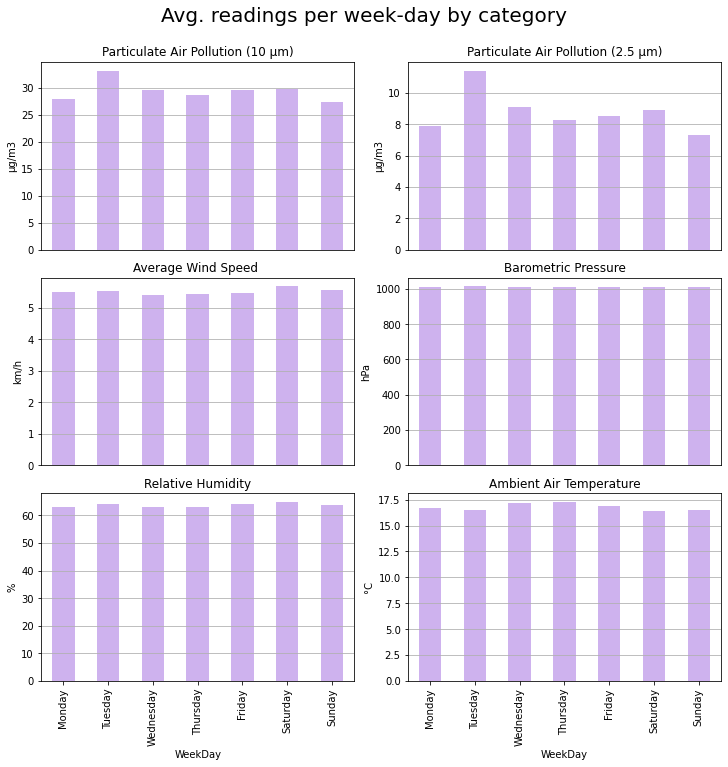

In [15]:
# setting the subplots and overall title
fig, ax = plt.subplots(3, 2, figsize=(5,5), constrained_layout=True)
fig.suptitle('Avg. readings per week-day by category', size = 20, color = 'black', y=1.05)

i_x = 0
i_y = 0

# iterate through the measurement types and make a bar plot for each crime category
u = 0
for measure in measuretypes:
    df_temp = df_reading_daily_grp[df_reading_daily_grp.measure == measure]
    df_temp.plot(kind = "bar", y = "value", x = 'WeekDay', 
                      legend = False, color='#CEB2EE', figsize=(10,10), ax = ax[i_x,i_y])
    ax[i_x,i_y].set_ylabel(measureunits[u])
    ax[i_x,i_y].set_title(measure, size = 12)
    ax[i_x,i_y].grid(axis='y')
    ax[i_x,i_y].axes.get_xaxis().set_visible(False)
    ax[2,0].axes.get_xaxis().set_visible(True)
    ax[2,1].axes.get_xaxis().set_visible(True)
    i_y +=1
    
    #fig.tight_layout()

    # reset subplot axes
    if i_y == 2:
        i_x +=1
        i_y =0
    u+=1   
    

# plt.savefig('weekday.png')
plt.show()

The plot above shows that there are no special weekly patterns for the microclimate measurement types, except for the Particulate Air Pollution, both with 10μm and 2.5μm particles. It seems that high measurements are usually recorded on Tuesdays and moderately high readings occur on Fridays and Saturdays.  

## Hours of the week

Let us investigate the patterns of the weekly-hours. We will use the hourly sensor readings. 

In [16]:
# keep measurements measuring on an hourly basis
df_reading_hrly = df_reading.loc[df_reading['type'].isin(['PM2.5-EPA-1h-NOPK', 'PM10-EPA-1h-NOPK', 'TPH.TEMP-EPA-1h', 'TPH.RH-EPA-1h', 'TPH.PRESSURE', 'WS'])]
df_reading_hrly.reset_index(inplace=True)

In [17]:
df_reading_hrly['Hour'] = df_reading_hrly['Date'].dt.hour
df_reading_hrly['WeekDay'] = pd.DatetimeIndex(df_reading_hrly['Date']).day_name().tolist()

# group the data by measurement and hour:
key = ['measure', 'WeekDay','Hour']
df_reading_daily_grph = df_reading_hrly.groupby(key,sort=False, as_index=False).mean()

In [18]:
# re-sort by day of the week:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# sort by day of the week and hour
cat_type = CategoricalDtype(categories=cats, ordered=True)
df_reading_daily_grph['WeekDay'] = df_reading_daily_grph['WeekDay'].astype(cat_type)
df_reading_daily_grph.sort_values('WeekDay', inplace=True)
df_reading_daily_grph.sort_values(['WeekDay','Hour'], inplace=True)

In [19]:
#create a column where both the day of the week and the hour are displayed
df_reading_daily_grph['WeekDay-short'] = df_reading_daily_grph['WeekDay'].str[:3]
df_reading_daily_grph['Hour-str'] = df_reading_daily_grph['Hour'].astype(str)
df_reading_daily_grph['WeekDay-Hour'] = df_reading_daily_grph[['WeekDay-short','Hour-str']].agg('-'.join, axis=1)

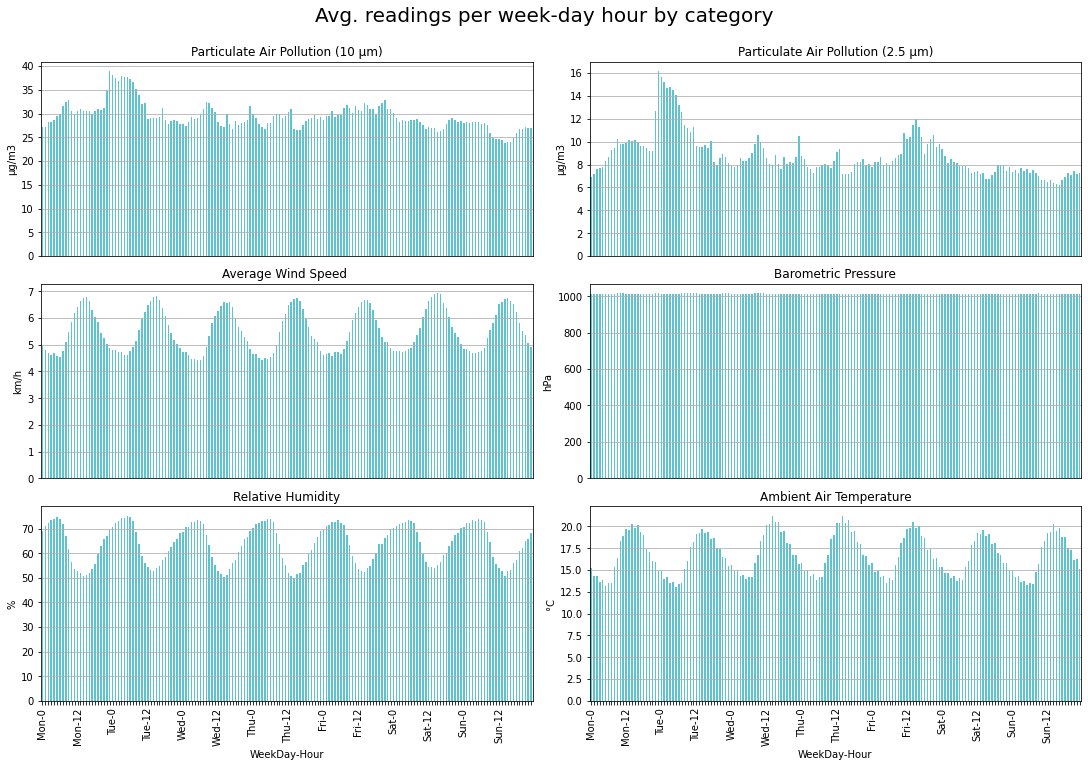

In [20]:
# setting the subplots and overall title
fig, ax = plt.subplots(3, 2, figsize=(10,10), constrained_layout=True)
fig.suptitle('Avg. readings per week-day hour by category', size = 20, y=1.05)

i_x = 0
i_y = 0

u = 0
# iterate through the measurement types and make a bar plot for each crime category
for measure in measuretypes:
    df_temp = df_reading_daily_grph[df_reading_daily_grph.measure == measure]
    df_temp.plot(kind = "bar", y = "value", x = 'WeekDay-Hour', 
                      legend = False, color='#5DC3CF', figsize=(15,10), ax = ax[i_x,i_y])
    
    for i, t in enumerate(ax[i_x,i_y].get_xticklabels()):
        if (i % 12) != 0:
            t.set_visible(False)

    ax[i_x,i_y].set_ylabel(measureunits[u])
    ax[i_x,i_y].set_title(measure, size = 12)
    ax[i_x,i_y].grid(axis='y')
    ax[i_x,i_y].axes.get_xaxis().set_visible(False)
    ax[2,0].axes.get_xaxis().set_visible(True)
    ax[2,1].axes.get_xaxis().set_visible(True)
    i_y +=1
    
    #fig.tight_layout()

    # reset subplot axes
    if i_y == 2:
        i_x +=1
        i_y =0
    u+=1   
# plt.savefig("weekdayhour.png")
plt.show()

Investigating the plots above, we notice some interesting patterns for Particulate Air Pollution, Ambient Air Temperature and Relative Humidity. The measurements correspond to an hourly rolled average. For the rest of the microclimate factors, it is not stated how often these measurements are taken and what timeframe they correspond for. It seems that Particulate Air Pollution for both air particle sizes is highest on Tuesdays, towards the beginning of the day. The ambient air temperature follows the same pattern for each weekday, being normally a bit higher in the middle of the day. The same can be said for the Average Wind Speed. The Relative Humidity follows the same pattern for every day of the week, seeming to peak more at the beginning of the day. The Barometric Pressure is almost the same regardless of the hour or the day of the week.  


A study in the Journal of the American Medical Association (https://www.ncbi.nlm.nih.gov/pubmed/11879110) estimates that for every 10 micrograms per cubic meter of particulate air pollutant (μg/m3) increase in fine particulate air pollution, there is an associated 4%, 6% and 8% increased risk of all-cause, cardiopulmonary and lung cancer mortality, respectively. Moreover, long-term exposure to PM2.5 may lead to plaque deposits in arteries, causing vascular inflammation and a hardening of the arteries which can eventually lead to heart attack and stroke

## Monthly Patterns

In [21]:
df_reading_daily['Month'] = df_reading_daily['Date'].dt.strftime('%b')

# group the data by measurement category and month:
key = ['measure', 'Month']
df_reading_monthly_grp = df_reading_daily.groupby(key, sort=False, as_index=False).mean()

In [22]:
# re-sort by day of the week:
cats = [ 'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# sort by day of the week and hour
cat_type = CategoricalDtype(categories=cats, ordered=True)
df_reading_monthly_grp['Month'] = df_reading_monthly_grp['Month'].astype(cat_type)
df_reading_monthly_grp.sort_values('Month', inplace=True)
df_reading_monthly_grp.sort_values(['Month'], inplace=True)

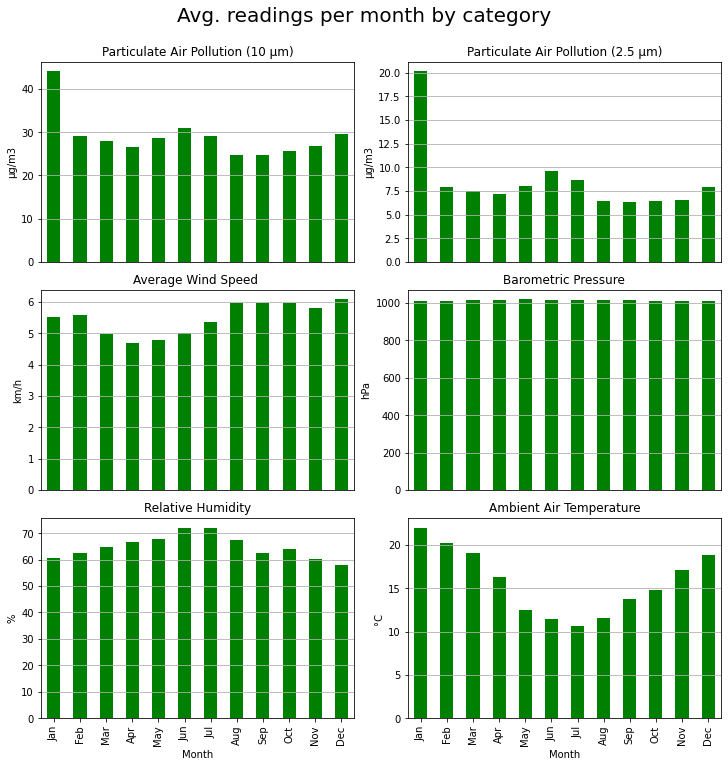

In [23]:
# setting the subplots and overall title
fig, ax = plt.subplots(3, 2, figsize=(5,5), constrained_layout=True)
fig.suptitle('Avg. readings per month by category', size = 20, color = 'black', y=1.05)

i_x = 0
i_y = 0

# iterate through the measurement types and make a bar plot for each crime category
u = 0
for measure in measuretypes:
    df_temp = df_reading_monthly_grp[df_reading_monthly_grp.measure == measure]
    df_temp.plot(kind = "bar", y = "value", x = 'Month', 
                      legend = False, color='#008000', figsize=(10,10), ax = ax[i_x,i_y])
    ax[i_x,i_y].set_ylabel(measureunits[u])
    ax[i_x,i_y].set_title(measure, size = 12)
    ax[i_x,i_y].grid(axis='y')
    ax[i_x,i_y].axes.get_xaxis().set_visible(False)
    ax[2,0].axes.get_xaxis().set_visible(True)
    ax[2,1].axes.get_xaxis().set_visible(True)
    i_y +=1
    
    #fig.tight_layout()

    # reset subplot axes
    if i_y == 2:
        i_x +=1
        i_y =0
    u+=1   
plt.savefig('monthly.png')   
plt.show()

Before discussing the monthly patterns, one thing to notice about Melbourne is that it is located in the Southern Empisphere. This means that June, July, August are actually winter months (the temperatures are low) and November, December, January are actually summer months (temperatures are high). Also, the readings are representative for microclimates in certain locations of Melbourne:

Particulate Air Pollution, 10 μm: It seems that there is a peak in January, but higher readings are also being measured in May, June, July and December. The summer months (January and December) are expected for high readings, since arid weather is usually loosening more dust into the air (https://blog.breezometer.com/summer-air-pollution-trends). However, the spikes in May, June and July are a bit harder to explain. 

Particulate Air Pollution, 2.5 μm: The same patterns are being noticed as for the 10 μm particles. However, the spike in January is huge compared with the rest of the readings. This could be due to the fact that more smaller dust particles are being present in the air. 

Average Wind Speed: The areas of Melbourne where the sensors are located are not that windy throughout the year. Furthermore, wind speed generally tends to be smaller on average in March, April, May and June.

Barometric Pressure: The barometric pressure seems to be constant throughout the whole year. 

Relative Humidity: The areas in Melbourne where the sensors are located tend to be quite humid throughout the whole year, which is in accordance to the general climate of Melbourne. Moreover, the humidity in those areas tends to be higher on average in the winter months. 

Ambient Air Temperature: As expected, the air temperature is higher in the winter months and lower in the summer months. Also, it seems that the temperature does not go below 10 degrees in winter, which could explain the high humidity in this period.  

# Visualizing geo-data

What we found as an interesting time-pattern was the hours-of-the week pattern for Particulate Air Pollution (2.5 µm), that is measured by the PM2.5-sensors. The PM2.5-sensors measure the average mass density of small particles in the air, which are smaller than 2.5 micrometers in diameter. 

It seems that the air is mostly polluted with small particles throughout the week-days, peaking between Tuesday towards the beginning of the day and Wednesday towards the end of the day. 

The following section will provide a heatmap of the location of the PM2.5-sensors throughout Melbourne, as well as a video showing the high readings development throughout the hours of the week. 

This we will do using another dataset which we were given, which contains the location of the sensors in Melbourne: https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Locations/irqv-hjr4 

This dataset is shown below:

In [24]:
# first, let's read in the location dataset
df_locations = pd.read_csv("Microclimate_Sensor_Locations.csv")
columns = ['site_id',"longitude","latitude","location"]
df_locations = df_locations[columns]
df_locations.head()

,site_id,longitude,latitude,location
0,1003,144.960923,-37.802300,POINT (144.960923 -37.8023)
1,1007,144.951835,-37.822460,POINT (144.951835 -37.82246)
2,1014,144.967222,-37.817500,POINT (144.967222 -37.8175)
3,1008,144.967057,-37.817465,POINT (144.96705703 -37.81746522)
4,1004,144.964635,-37.800575,POINT (144.964635 -37.800575)


In [25]:
df_locations1 = pd.read_csv("Microclimate_Sensor_Locations.csv")
df_locations1.head(100)

,site_id,gateway_hub_id,description,last_data,site_status,start_reading,end_reading,longitude,latitude,location
0,1003,arc1047,Pelham Street between Bouverie Street and Leic...,NaN,R,2019/11/15,2021/06/13,144.960923,-37.802300,POINT (144.960923 -37.8023)
1,1007,arc1113,Siddeley Street between Spencer Street and Wur...,2022/04/14 09:00:01 PM,C,2021/05/20,NaN,144.951835,-37.822460,POINT (144.951835 -37.82246)
2,1014,arc1045,Flinders Street between Swanston Street and El...,2022/04/14 09:00:01 PM,C,2021/09/17,NaN,144.967222,-37.817500,POINT (144.967222 -37.8175)
3,1008,arc1045,Flinders Street between Swanston Street and El...,NaN,R,2021/06/14,2021/06/20,144.967057,-37.817465,POINT (144.96705703 -37.81746522)
4,1004,arc1048,Grattan Street between Cardigan Street and Swa...,NaN,R,2019/11/15,2021/06/13,144.964635,-37.800575,POINT (144.964635 -37.800575)
5,1012,arc1048,Little Collins Street between Exhibition Stree...,2022/04/14 08:00:01 PM,C,2021/09/17,NaN,144.970000,-37.813333,POINT (144.97 -37.813333)
6,1009,arc1050,Flinders Lane between Swanston Street and Eliz...,2022/04/14 09:00:01 PM,C,2021/06/14,NaN,144.965705,-37.816868,POINT (144.96570467 -37.81686763)
7,1013,arc1047,William Street between Little Lonsdale Street ...,2022/04/14 09:00:01 PM,C,2021/09/17,NaN,144.956389,-37.811944,POINT (144.956389 -37.811944)
8,1010,arc1112,"Melbourne Convention Centre Carpark, approxima...",2022/04/14 09:00:01 PM,C,2021/06/29,NaN,144.952222,-37.822500,POINT (144.95222195 -37.82250002)
9,1015,arc1046,Spring Street between Little Bourke Street and...,2022/04/14 09:00:01 PM,C,2021/09/17,NaN,144.972500,-37.810278,POINT (144.9725 -37.810278)


We merge this dataset with the readings dataset which contains the air particle measurements, df_reading, keeping only the hourly average readings of Particulate Air Pollution (2.5 µm) - this corresponds to choose the reading type: 'PM2.5-EPA-1h-NOPK'

In [26]:
# and merge it with the reading dataset:
df_locations_reading = pd.merge(df_reading, df_locations, left_on='site_id', right_on='site_id', how='left')

In [27]:
df_locations.head(5)

,site_id,longitude,latitude,location
0,1003,144.960923,-37.802300,POINT (144.960923 -37.8023)
1,1007,144.951835,-37.822460,POINT (144.951835 -37.82246)
2,1014,144.967222,-37.817500,POINT (144.967222 -37.8175)
3,1008,144.967057,-37.817465,POINT (144.96705703 -37.81746522)
4,1004,144.964635,-37.800575,POINT (144.964635 -37.800575)


Using the location datatset we can create a heatmap showing the location of the PM2.5-sensors around Melbourne:

In [28]:
# choice of measurement category
df_readings_pm = df_locations_reading.loc[df_reading['type']=='PM2.5-EPA-1h-NOPK']

#instantiating Melbourne map
map_Melbourne = folium.Map(location=[-37.820935, 144.946457],
                    zoom_start = 13) 
# add a marker for the town hall
folium.Marker([-37.815145, 144.9667776], popup='Melbourne Town Hall', tooltip='Melbourne Town Hall', icon=folium.Icon(color="green")).add_to(map_Melbourne)

In [29]:
from folium import plugins
from folium.plugins import HeatMap

df_readings_pm_unique = df_readings_pm.drop_duplicates(subset=['site_id'])
# rename latitude and longitude columns for simplicity
df_readings_pm_unique['X'] = ''
df_readings_pm_unique['Y'] = ''
# Ensure you're handing it floats
df_readings_pm_unique.loc[:,'X'] = df_readings_pm_unique.loc[:,'latitude'].astype(float)
df_readings_pm_unique.loc[:,'Y'] = df_readings_pm_unique.loc[:,'longitude'].astype(float)

heat_df = df_readings_pm_unique[['X', 'Y']]
heat_df = heat_df.dropna(axis=0, subset=['X','Y'])

# List comprehension to make out list of lists
heat_data = [[row['X'],row['Y']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=12, blur=5, gradient={0.4: 'blue', 0.65: 'yellow',  0.85: 'orange', 1: 'red'}).add_to(map_Melbourne)

# Display the map
map_Melbourne

The map displays the location of the microclimate sensors measuring the air quality. 
More sensors are located in the South Warf region. If one zooms in, one can see that there are actually 4 PM2.5-sensors installed in the Melbourne Convention Centre Parking, which is located on Siddeley Street.
        
More sensors are located in the Carlton region, namely 4 on Grattan Street and one on Pelham Street.

The rest of the sensors spread out around some streets in the central area of Melbourne. The specific streets are: Flinders Street (Station Swanson), Flinders Lane, Little Collins Street, Lonsdale Street, intersection between La Trobe Street and William Street (Flagstaff Station), Spring Street



## HeatMap with a weekly-hourly time resolution

The HeatMapWithTime presented in this section will try to dig deeper into the weekly-hourly time pattern presented in the **Temporal Patterns** section, focusing on high readings of small air pollutants. 

First, we have to filter out the readings and keep only the ones which were above a certain threshold. 

Fine particulate matter (PM2.5) is an air pollutant that is a concern for people's health when levels in air are high for a longer period of time. A study in the Journal of the American Medical Association (https://www.ncbi.nlm.nih.gov/pubmed/11879110) estimates that for every 10 micrograms per cubic meter (μg/m3) increase in fine particulate air pollution, there is an associated 4%, 6% and 8% increased risk of all-cause, cardiopulmonary and lung cancer mortality, respectively.

Based also on the hourly-weekly pattern plot, we can choose a threshold for high PM2.5 which could cause health problems: 11 μg/m3

In [30]:
# choice of measurement category
df_readings_pm = df_locations_reading.loc[df_reading['type']=='PM2.5-EPA-1h-NOPK']

# filter out the smaller readings base on a threshold:
df_readings_pm = df_readings_pm[df_readings_pm['value']>11]

In [31]:

# rename latitude and longitude columns for simplicity
df_readings_pm['X'] = ''
df_readings_pm['Y'] = ''
# Ensure you're handing it floats
df_readings_pm.loc[:,'X'] = df_readings_pm.loc[:,'latitude'].astype(float)
df_readings_pm.loc[:,'Y'] = df_readings_pm.loc[:,'longitude'].astype(float)

# extract the hour and week-day from the Date
df_readings_pm['Date'] = df_readings_pm['Date'].sort_values(ascending=True)
df_readings_pm['Hour'] = df_readings_pm['Date'].dt.hour
df_readings_pm['WeekDay'] = pd.DatetimeIndex(df_readings_pm['Date']).day_name().tolist()

# group by year and month to see monthly development throughout time
df4 = df_readings_pm.groupby(['WeekDay','Hour'])

In [32]:
data = []

for _, d in df4:
    data.append([[row['X'], row['Y']] for _, row in d.iterrows()])

df5 = df4.size().to_frame()

In [33]:
df5['WeekDay_col'] = df5.index.get_level_values(0)
df5['Hour_col'] = df5.index.get_level_values(1)

# re-sort by day of the week:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# sort by day of the week and hour
cat_type = CategoricalDtype(categories=cats, ordered=True)
df5['WeekDay_col'] = df5['WeekDay_col'].astype(cat_type)
df5.sort_values('WeekDay_col', inplace=True)
df5.sort_values(['WeekDay_col','Hour_col'], inplace=True)

In [34]:
# create a list of dates to be used as map index
idx_list = df5.index.tolist()
idx_list_dates = []
for i in idx_list:
    weekday = str(i[0])
    hour = str(i[1])
    idx_list_dates.append(weekday + '-' + hour)

In [35]:
# choice of measurement category
df_readings_pm = df_locations_reading.loc[df_reading['type']=='PM2.5-EPA-1h-NOPK']

#instantiating Melbourne map
map_Melbourne = folium.Map(location=[-37.810935, 144.956457],
                    zoom_start = 14) 
# add a marker for the town hall
folium.Marker([-37.815145, 144.9667776], popup='Melbourne Town Hall', tooltip='Melbourne Town Hall', icon=folium.Icon(color="green")).add_to(map_Melbourne)

# create the heatmap with timestamps
hm = plugins.HeatMapWithTime(data, auto_play=True,
                             display_index=True,
                             radius=11,gradient={0.4: 'blue', 0.65: 'yellow',  0.85: 'orange', 1: 'red'},
                             index=idx_list_dates,
                             index_steps = 0.1,
                             min_speed = 1,
                             max_speed = 20,
                             max_opacity=0.8)
hm.add_to(map_Melbourne)
map_Melbourne

Since the HeatMap video automatically starts with 1fps, one is encouraged to move the fps slider to about 6-8fps. 
The HeatMapWithTime shows the high air particle density measurements (>10 μg/m3) which were read by the PM2.5-sensors.  

One is ecnouraged to zoom in on each region which is more highlighted:

**South Wharf - zoom in to Melbourne Convention Centre Parking:**

What one should look at for the Melbourne Convention Centre Parking is when 3-4 sensors are lighting up simultaneously. This means there is likely high air particle pollution around the building. It seems that high air pollution readings are mostly on the week-days, usually at the beginning and the end of the day, but also on Saturday in the middle of the day. Tuesdays are especially high air pollution readings around the building for most of the day, but Sunday less high readings are being registered.

The high readings could be caused by the fact that a lot of the parking area is being in use by cars. It seems that especially on Tuesdays and Saturdays, a lot of the parking spots might be occupied. The parking is most likely being used by those who are visiting the Melbourne Convention Exhibition Centre. So on these days there is a chance that there are more visitors, but this is rather an assumption. 

**Carlton - zoom in to Grattan Street**

It seems that there are a number of constant high readings spread throughout the whole week, when it comes to air pollution. This could be due to constant traffic.   

**Central area of Melbourne**

For the central area of Melbourne, restricted more around the Town Hall, the sensors are spread out on different streets. This means that throughout the video one should pay attention when most of the 5 sensors are lighting up for longer periods of time, meaning there might be a chance that the central zone has a high air pollution within a certain time-span. 

Most PM-2.5 sensors record high air pollution readings throughout Monday at the beginning and end of the day. High readings are recorded for most of the day on Tuesday-Thursday. Friday, usually at the end of the day, there are more high readings recorded, as well as Saturday and Sunday in the middle of the day. This could be tied to how busy the central area is in this time-period. 

Another thing to note is that the Station Swanson on Flinders Street records high air pollution readings throughout most of the week period. This could be due to the fact that the station is placed at the intersection of Flinders Street, where there could be constant traffic.

Overall, this HeatMap is not as reliable since it takes all measurements into consideration, but it gives us an idea about the temporal patterns discovered.

## Heatmap for Weekly development

Another interesting thing regarding the air pollutants was the seasonal development: it seems that concentrations on average are highest in January. To study the seasonal patterns more closely, we have decided to look at the seasonal weekly development - that is, showing how many high readings of small air pollutants above 11 μg/m3 are recorded throughout the weeks between 2021-2022.

In [36]:
# choice of measurement category
df_readings_pm = df_locations_reading.loc[df_reading['type']=='PM2.5-EPA-1h-NOPK']

# filter out the smaller readings base on a threshold:
df_readings_pm = df_readings_pm[df_readings_pm['value']>11]

# rename latitude and longitude columns for simplicity
df_readings_pm['X'] = ''
df_readings_pm['Y'] = ''
# Ensure you're handing it floats
df_readings_pm.loc[:,'X'] = df_readings_pm.loc[:,'latitude'].astype(float)
df_readings_pm.loc[:,'Y'] = df_readings_pm.loc[:,'longitude'].astype(float)

# get week number
df_readings_pm['Weeks'] = df_readings_pm['Date'].dt.isocalendar().week

In [37]:
# sort values and convert values to floats
df_readings_pm['Weeks'] = df_readings_pm['Weeks'].sort_values(ascending=True)
df_readings_pm['X'] = df_readings_pm['X'].astype(float)
df_readings_pm['Y'] = df_readings_pm['Y'].astype(float)
df_readings_pm['Weeks'] = df_readings_pm['Weeks'].astype(float)


#df_readings_pm = df_readings_pm.dropna(axis=0, subset=['Y','X','Weeks'])

data = []
df4 = df_readings_pm.groupby('Weeks')
for _, d in df4:
    data.append([[row['X'], row['Y']] for _, row in d.iterrows()])

In [38]:
# del dict
# add a lable for each week number
df_readings_pm['M'] = df_readings_pm['Date'].dt.strftime('%b')
df_readings_pm['Y'] = df_readings_pm['Date'].dt.year
df_readings_pm['WeekMonthYear'] = 'Week' + df_readings_pm['Weeks'].astype(int).astype(str) + '-' + df_readings_pm['M'].astype(str) + df_readings_pm["Y"].astype(str)
#df_readings_pm.loc[:,'Weeks'] = df5['Weeks'].astype(int)

# make a dictionary between week number and label
d_labels = dict(zip(df_readings_pm.Weeks,df_readings_pm.WeekMonthYear))

In [39]:
# add the label to the grouped dataframe
df5 = df4.size().to_frame()
df5.reset_index(inplace=True)
df5['label']= df5['Weeks'].map(d_labels)
idx_labels = df5['label'].tolist()

In [40]:
#instantiating Melbourne map
map_Melbourne = folium.Map(location=[-37.810935, 144.956457],
                    zoom_start = 14) 

# add a marker for the town hall
folium.Marker([-37.815145, 144.9667776], popup='Melbourne Town Hall', tooltip='Melbourne Town Hall', icon=folium.Icon(color="green")).add_to(map_Melbourne)

# HeatMapWithTime
#hm = plugins.HeatMapWithTime(data, auto_play=True, index = idx_labels, max_opacity=0.8)
# create the heatmap with timestamps
hm = plugins.HeatMapWithTime(data, auto_play=True,
                             display_index=True,
                             radius=11,gradient={0.4: 'blue', 0.65: 'yellow',  0.85: 'orange', 1: 'red'},
                             index=idx_labels,
                             index_steps = 0.1,
                             min_speed = 1,
                             max_speed = 20,
                             max_opacity=0.8)
hm.add_to(map_Melbourne )
map_Melbourne

As the video shows, a lot of high readings of small air pollutants are being recorded (>11 μg/m3) in the beginning of 2021, starting from January to the final weeks of April. 

The PM2.5-sensors don't record as many high readings in the weeks of May-Aug around the town hall area, except for the intersection on Flinders Street. More high readings of small air pollutants are read again starting from Sept until the beginning of January, peaking in November and December.

This is highly likely due to the fact that in Australia, the seasons are inversed. This means that warm temperatures are mostly occurring during the 'winter' months, that is: Nov, Dec, Jan. Summertime pollution often spikes due to arid weather loosening more dust into the air. This could explain the fluctuation of high air pollutant readings around the town hall area.

The focal traffic points which are located on: Grattan Street, Flinders Street and Melbourne Convention Centre Parking seem to have constant high air pollutants, but a bit mildly less during some weeks of the months with cold temperatures: June, July and August.

### Temporal development of fluctuating values for each time of measurement 

  In this part of the assignment we will take a look at how the values change during each month: 

In [41]:
df_reading["date"] =pd.to_datetime(df_reading['Date']).dt.date
columns = ["measure","value","date"]
df_reading_new = df_reading[columns]

In [42]:
df_reading.measure.unique()

array(['Particulate Air Pollution (2.5 µm)',
       'Particulate Air Pollution (10 µm)', 'Ambient Air Temperature',
       'Relative Humidity', 'Barometric Pressure', 'Average Wind Speed '],
      dtype=object)

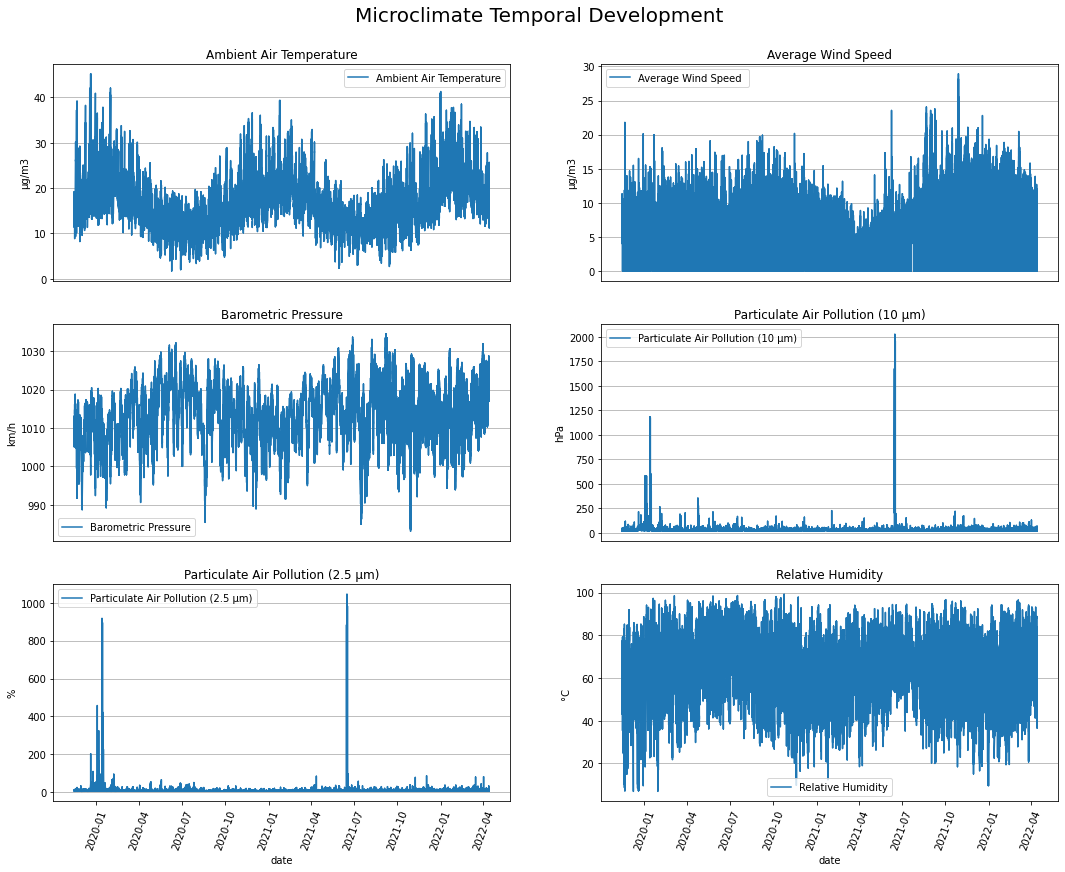

In [43]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 2)
fig.suptitle('Microclimate Temporal Development', size = 20, color = 'black', y=0.98)
u = 0
i_x = 0
i_y = 0
measure_types = ['Ambient Air Temperature', 'Average Wind Speed',
                 'Barometric Pressure','Particulate Air Pollution (10 µm)',
                 'Particulate Air Pollution (2.5 µm)','Relative Humidity' ]

plt.subplots_adjust(left=None, bottom=-0.4, right=None, top=None, wspace=None, hspace=None)

# key gives the group name (i.e. category), data gives the actual values
for key, data in df_reading_new.groupby('measure'):

    data.plot(x='date', y='value', ax=ax[i_x,i_y], figsize=(18,8), label=key)
    plt.setp( ax[i_x,i_y].xaxis.get_majorticklabels(), rotation=70 )
    ax[i_x,i_y].set_ylabel(measureunits[u])
    ax[i_x,i_y].set_title(measure_types[u], size = 12)
    ax[i_x,i_y].grid(axis='y')
    ax[i_x,i_y].axes.get_xaxis().set_visible(False)
    ax[2,0].axes.get_xaxis().set_visible(True)
    ax[2,1].axes.get_xaxis().set_visible(True)
    
    i_y +=1
    
    #fig.tight_layout()

    # reset subplot axes
    if i_y == 2:
        i_x +=1
        i_y =0
    u+=1   
    #ax[i_x,i_y].set_xticklabels(ax[i_x,i_y].get_xticks(), rotation = 45)

The graphs above track the evolution of each of the unique measures throughout the entire timeline of the dataset. The two graphs that present the most considerate changes are the Particulate area polution graphs for 10 micro meters and 2.5micro meters. We can see that both graphs show a considerate peak at 2020-01 and at 2021-10, these two peaks weren't as visible in the monthly overview graphs as the values were averaged. Besides the two peaks, there is a small decrease in the value for the particulate air polution between the start and the end of the timeline

### More data processing for microclimate sensor readings:

We will calculate the daily averages for sensor readings and use those for creating a final dataset to make predictions on. 

In [44]:
df_locations_reading.head(10)
print(min(df_locations_reading['Date']))
print(max(df_locations_reading['Date']))

2019-11-15 09:00:00
2022-04-14 21:00:03


In [45]:
# keep only daily average frequencies
df_locations_reading_daily = df_locations_reading[(df_locations_reading['frequency'] == 'hourly')]

# convert Date to keep only the year, month, day
df_locations_reading_daily['Date_day'] = df_locations_reading_daily['Date'].dt.strftime('%Y-%m-%d')


# keep a dictionary units per measurement type
d_label_units = dict(zip(df_locations_reading_daily.measure,df_locations_reading_daily.units))

# keep a dictionary site_id: latitude
d_site_latitude = dict(zip(df_locations_reading_daily.site_id,df_locations_reading_daily.latitude))

# keep a dictionary site_id: longitude
d_site_longitude = dict(zip(df_locations_reading_daily.site_id,df_locations_reading_daily.longitude))


# group the data by measurement category and date:
key = ['measure', 'Date_day','site_id']
df_locations_reading_daily_grp = df_locations_reading_daily.groupby(key, sort=False, as_index=False).mean()


# add the units
df_locations_reading_daily_grp['units'] = df_locations_reading_daily_grp['measure'].map(d_label_units)

# add the latitude
df_locations_reading_daily_grp['latitude'] = df_locations_reading_daily_grp['site_id'].map(d_site_latitude)
# add the latitude
df_locations_reading_daily_grp['longitude'] = df_locations_reading_daily_grp['site_id'].map(d_site_longitude)


# keep a unique set of the dates (for filtering later)
set_dates_df_measurements = set(df_locations_reading_daily.Date_day.unique())

# keep columns of interest
df_measurements_average = df_locations_reading_daily_grp[['measure','Date_day','value','site_id','latitude','longitude']]

In [46]:
df_measurements_average

,measure,Date_day,value,site_id,latitude,longitude
0,Particulate Air Pollution (2.5 µm),2019-11-15,6.513333,1001,-37.800793,144.966492
1,Particulate Air Pollution (10 µm),2019-11-15,28.693333,1001,-37.800793,144.966492
2,Ambient Air Temperature,2019-11-15,16.604667,1001,-37.800793,144.966492
3,Relative Humidity,2019-11-15,52.448000,1001,-37.800793,144.966492
4,Particulate Air Pollution (2.5 µm),2019-11-15,5.866667,1002,-37.800524,144.964122
...,...,...,...,...,...,...
17759,Ambient Air Temperature,2022-04-10,21.787500,1014,-37.817500,144.967222
17760,Ambient Air Temperature,2022-04-10,21.732083,1015,-37.810278,144.972500
17761,Particulate Air Pollution (10 µm),2022-04-10,20.217391,1011,-37.822222,144.952222
17762,Particulate Air Pollution (10 µm),2022-04-10,23.500000,1016,-37.812778,144.960556


# Social Aspect
#### We will use the data for for pedestrian count sensors accross Melbourne:

In [47]:
df_ped_reading = pd.read_csv("Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv")
df_ped_location = pd.read_csv("Pedestrian_Counting_System_-_Sensor_Locations.csv")

# merge the two datasets based on sensor ID
df_ped_read_loc = pd.merge(df_ped_reading, df_ped_location, left_on='Sensor_ID', right_on='sensor_id', how='left')

In [48]:
# we can deleted now Dataframe objects which we do not longer use to free up space
del df_ped_reading
del df_ped_location
del [[df_reading, df_reading_daily, df_reading_daily_grp, df_temp, df_reading_hrly, df_reading_daily_grph, df_reading_monthly_grp, df_locations, df_readings_pm, heat_df, df4, df5]] 

In [49]:
print(min(df_ped_read_loc['Date_Time']))
print(max(df_ped_read_loc['Date_Time']))

April 01, 2010 01:00:00 AM
September 30, 2021 12:00:00 PM


#### Let's process this dataset so it aligns with the microclimate sensor readings:

In [50]:
# keep only readings after 2009:
df_ped_read_loc = df_ped_read_loc[df_ped_read_loc.Year >= 2019]

df_ped_read_loc['Date_day'] = pd.to_datetime(df_ped_read_loc['Date_Time'])
#df_ped_read_loc['Date_day'] = df_ped_read_loc['Date_Time'].dt.strftime('%Y-%m-%d')

In [51]:
# set a column date:
df_ped_read_loc['Date_day'] = df_ped_read_loc['Date_day'].dt.strftime('%Y-%m-%d')

# convert Date to keep only the year, month, day
#df_ped_read_loc['Date_day'] = df_ped_read_loc['Datetime'].dt.strftime('%Y-%m-%d %H')

In [52]:
# keep columns of interest
df_ped_read_loc = df_ped_read_loc[['Sensor_ID','Date_day','Hourly_Counts','latitude','longitude','location']]

Filter out the data in for df_ped_read_loc (the pedestrian count sensor readings) based on the common dates which are also present in df_measurements_average (daily average of microclimate sensor readings)

In [53]:
# keep a unique set of the dates (for filtering)
set_dates_df_pedestrians = set(df_ped_read_loc.Date_day.unique())

# find the intersection of those dates from df_ped_read_loc and df_measurements_average
dates_intersect = set_dates_df_pedestrians.intersection(set_dates_df_measurements)

# filter out the dates for pedestrian sensor readings
df_ped_read_loc = df_ped_read_loc[df_ped_read_loc['Date_day'].isin(list(dates_intersect))]

# filter out the dates for microclimate sensor readings
df_microclimate_readings = df_measurements_average[df_measurements_average['Date_day'].isin(list(dates_intersect))]

# we can delete now Dataframe objects which we do not longer use to free up space
del [[df_measurements_average, df_locations_reading_daily]]

In [54]:
print('We have {} overlapping dates of microclimate readings and pedestrian counts.'.format(len(dates_intersect)))
print('The earliest measurements was taken on {} and the latest on {}'.format(max(df_ped_read_loc['Date_day']),min(df_ped_read_loc['Date_day'])))

We have 867 overlapping dates of microclimate readings and pedestrian counts.
The earliest measurements was taken on 2022-03-31 and the latest on 2019-11-15


In [55]:
df_microclimate_readings.to_csv('df_microclimate_readings.csv')
df_ped_read_loc.to_csv('df_ped_read_loc.csv')

# Data Merging

In [56]:
# we load previously saved data
df_ped_read_loc = pd.read_csv('df_ped_read_loc.csv')
df_microclimate_readings = pd.read_csv('df_microclimate_readings.csv')

Create a daily average for the pedestrian count readings:

In [57]:
#del dict
# keep a dictionary site_id: latitude
d_site_latitude = dict(zip(df_ped_read_loc.Sensor_ID,df_ped_read_loc.latitude))

# keep a dictionary site_id: longitude
d_site_longitude = dict(zip(df_ped_read_loc.Sensor_ID,df_ped_read_loc.longitude))


# group the data by sensor id and date:
key = ['Sensor_ID', 'Date_day']
# take an average measurement on the day
df_ped_read_loc_grp = df_ped_read_loc.groupby(key, sort=False, as_index=False).mean()

# keep columns of interest
df_pedestrians_avg = df_ped_read_loc_grp[['Date_day','Sensor_ID','Hourly_Counts']]

# add original lat and long columns
df_pedestrians_avg['latitude'] = df_pedestrians_avg['Sensor_ID'].map(d_site_latitude)

df_pedestrians_avg['longitude'] = df_pedestrians_avg['Sensor_ID'].map(d_site_longitude)

In [58]:
# we can delete now Dataframe objects which we do not longer use to free up space
del [[df_ped_read_loc_grp, df_ped_read_loc]]

Plot the location of the pedestrian sensors, alongside with the microclimate sensor. We have added pins as delimiters for the regions of interest.

In [59]:

#instantiating Melbourne map
map_Melbourne = folium.Map(location=[-37.810935, 144.956457],
                    zoom_start = 13) 

# Add border lines where there is a close range of readings in the region

# longitude limits
west_points = [
    [-37.715145, 144.9747798],
    [-37.815145, 144.9747798],
    [-37.915145, 144.9747798],]

#add lines
folium.PolyLine(west_points, color="red", weight=2.5, opacity=1).add_to(map_Melbourne)

east_points = [
    [-37.715145, 144.9487798],
    [-37.815145, 144.9487798],
    [-37.915145, 144.9487798],]

#add lines
folium.PolyLine(east_points, color="red", weight=2.5, opacity=1).add_to(map_Melbourne)

# latitude limits
south_points = [
    [-37.824045, 144.9787798],
    [-37.824045, 144.9187798],
    [-37.824045, 144.9987798],]

#add lines
folium.PolyLine(south_points, color="red", weight=2.5, opacity=1).add_to(map_Melbourne)

north_points = [
    [-37.798000, 144.9787798],
    [-37.798000, 144.9187798],
    [-37.798000, 144.9987798],]

#add lines
folium.PolyLine(north_points, color="red", weight=2.5, opacity=1).add_to(map_Melbourne)

## Microclimate readings ##
df_microclimate_readings2 = df_microclimate_readings.drop_duplicates(subset=['site_id'])
# rename latitude and longitude columns for simplicity
df_microclimate_readings2['X'] = ''
df_microclimate_readings2['Y'] = ''
# Ensure you're handing it floats
df_microclimate_readings2.loc[:,'X'] = df_microclimate_readings2.loc[:,'latitude'].astype(float)
df_microclimate_readings2.loc[:,'Y'] = df_microclimate_readings2.loc[:,'longitude'].astype(float)

heat_df = df_microclimate_readings2[['X', 'Y']]
heat_df = heat_df.dropna(axis=0, subset=['X','Y'])

# List comprehension to make out list of lists
heat_data_microclimate = [[row['X'],row['Y']] for index, row in heat_df.iterrows()]


## Pedestrian Count readings ##
df_pedestrians_avg2 = df_pedestrians_avg.drop_duplicates(subset=['Sensor_ID'])
# rename latitude and longitude columns for simplicity
df_pedestrians_avg2['X'] = ''
df_pedestrians_avg2['Y'] = ''
# Ensure you're handing it floats
df_pedestrians_avg2.loc[:,'X'] = df_pedestrians_avg2.loc[:,'latitude'].astype(float)
df_pedestrians_avg2.loc[:,'Y'] = df_pedestrians_avg2.loc[:,'longitude'].astype(float)

heat_df = df_pedestrians_avg2[['X', 'Y']]
heat_df = heat_df.dropna(axis=0, subset=['X','Y'])

# List comprehension to make out list of lists
heat_data_pedestrians = [[row['X'],row['Y']] for index, row in heat_df.iterrows()]

# Plot it on the map - pedestrians
HeatMap(heat_data_pedestrians, radius=8, blur=1, gradient={0.4: 'hotpink', 0.75: 'blueviolet',  1: 'rebeccapurple'}).add_to(map_Melbourne)

# Plot it on the map - microclimate
HeatMap(heat_data_microclimate, radius=12, blur=1, gradient={0.4: 'skyblue', 0.75: 'deepskyblue',  1: 'cadetblue'}).add_to(map_Melbourne)
#map_Melbourne.save("map_datamerging_1.html")
# Display the map
map_Melbourne

As we observe on the map, there is a special region in the center of Melbourne where the locations of the microclimate sensors (blue and red) are within a close distance region with the sensors which are counting pedestrians (yellow and pink). The red lines on the map are delimiting that region, which includes: the Melbourne Central district, Carlton, part of South Wharf and Southbank. 

There are a lot of sensors counting pedestrians within the region delimited by the red lines. Thus, we assumed that, within this region, the daily averages of the pedestrians and daily averages of the sensor readings might be correlated. Thus, by knowing the latitude and longitude limits, we can filter now the data for the pedestrian count readings. 

This means to filter out the data in for df_ped_read_loc (the pedestrian count sensor readings), so it within the are of the locations of the microclimate sensor readings. 

In [60]:
# lat and long limit based on the red-lined quadrant
lat_limit_south = -37.824045
lat_limit_north = -37.798000
long_limit_east = 144.9487798
long_limit_west = 144.9747798

# filtering out pedestrian readings which are within the dataset
df_pedestrians_avg = df_pedestrians_avg.loc[(df_pedestrians_avg['latitude'] >= lat_limit_south) & (df_pedestrians_avg['latitude'] <= lat_limit_north)]
df_pedestrians_avg = df_pedestrians_avg.loc[(df_pedestrians_avg['longitude'] >= long_limit_east) & (df_pedestrians_avg['longitude'] <= long_limit_west)]

In [61]:
print("We have {} daily averages of pedestrian count readings in the overlapping range and timeframe".format(len(df_pedestrians_avg)))

We have 49337 daily averages of pedestrian count readings in the overlapping range and timeframe


In [62]:
df_ped_location = pd.read_csv("Pedestrian_Counting_System_-_Sensor_Locations.csv")
# filtering out pedestrian readings which are within the dataset
df_ped_location = df_ped_location.loc[(df_ped_location['latitude'] >= lat_limit_south) & (df_ped_location['latitude'] <= lat_limit_north)]
df_ped_location = df_ped_location.loc[(df_ped_location['longitude'] >= long_limit_east) & (df_ped_location['longitude'] <= long_limit_west)]
print("We have {} locations of pedestrian counting sensor in the overlapping range".format(len(df_ped_location)))

We have 70 locations of pedestrian counting sensor in the overlapping range


Of course, more processing is needed. We can further divide the area of interest into two subregions, according to the microclimate patterns observed. Those can be: South Wharf, Flinders, Central Area and Carlton. Namely, we can add these lines:

In [63]:

# South Wharf limit ########
southwarf_points = [
    [-37.820045, 144.9787798],
    [-37.820045, 144.9187798],
    [-37.820045, 144.9987798],]

#add lines
folium.PolyLine(southwarf_points, color="purple", weight=2.5, dash_array='15', opacity=1).add_to(map_Melbourne)

# Flinders Street limit ########
flinders_points = [
    [-37.815045, 144.9787798],
    [-37.815045, 144.9187798],
    [-37.815045, 144.9987798],]

#add lines
folium.PolyLine(flinders_points, color="purple", weight=2.5, dash_array='15', opacity=1).add_to(map_Melbourne)

# Carlton limit ########
carlton_points = [
    [-37.804245, 144.9787798],
    [-37.804245, 144.9187798],
    [-37.804245, 144.9987798],]

#add lines
folium.PolyLine(carlton_points, color="purple", weight=2.5, dash_array='15', opacity=1).add_to(map_Melbourne)

#add lines
folium.PolyLine(north_points, color="red", weight=2.5, opacity=1).add_to(map_Melbourne)
#map_Melbourne.save("map_datamerging_2.html")
# Display the map
map_Melbourne

Now we can add a new location category based on these geo-delimiters: 

In [64]:
limit_south_lat = lat_limit_south
limit_southwarf_lat = -37.820045
limit_flinders_lat = -37.815045 
limit_carlton_lat = -37.804245
limit_north_lat = lat_limit_north

# conditions for delimitng the regions based on latitude limits:
conditions = [
    (df_pedestrians_avg['latitude'] < limit_southwarf_lat),
    (df_pedestrians_avg['latitude'] >= limit_southwarf_lat) & (df_pedestrians_avg['latitude'] < limit_flinders_lat),
    (df_pedestrians_avg['latitude'] > limit_flinders_lat) & (df_pedestrians_avg['latitude'] < limit_carlton_lat),
    (df_pedestrians_avg['latitude'] >= limit_carlton_lat)
]

# adding a new Region categorcal column
values = ['SouthWarf', 'Flinders', 'Central', 'Carlton']

df_pedestrians_avg['Region'] = np.select(conditions, values)

Now we can take a daily average of the pedestrian counts within those regions:

In [65]:
# group the data by date and delimited region:
key = ['Date_day','Region']
# take an average measurement on the day
df_pedestrians_avg = df_pedestrians_avg.groupby(key, sort=False, as_index=False).mean()

We do the same procedure with the microclimate sensor readings

In [66]:

# conditions for delimitng the regions based on latitude limits:
conditions = [
    (df_microclimate_readings['latitude'] < limit_southwarf_lat),
    (df_microclimate_readings['latitude'] >= limit_southwarf_lat) & (df_microclimate_readings['latitude'] < limit_flinders_lat),
    (df_microclimate_readings['latitude'] > limit_flinders_lat) & (df_microclimate_readings['latitude'] < limit_carlton_lat),
    (df_microclimate_readings['latitude'] >= limit_carlton_lat)
]

# adding a new Region categorcal column
values = ['SouthWarf', 'Flinders', 'Central', 'Carlton']

df_microclimate_readings['Region'] = np.select(conditions, values)

In [67]:
# first, we make a daily average for the microclimate readings, based on the type, sensor id and date:
# group the data by date and delimited region:
key = ['Date_day','Region','measure']
# take an average measurement on the day
df_microclimate_readings = df_microclimate_readings.groupby(key, sort=False, as_index=False).mean()
print("We have {} daily averages of microclimate readings in the overlapping range and timeframe".format(len(df_microclimate_readings)))

We have 5500 daily averages of microclimate readings in the overlapping range and timeframe


Now we can merge the two datasets (pedestrian and microclimate readings) based on the Date_day and Region:

In [68]:
# now we can add the Pedestrian count values based on the date and region:
df_avgDaily_readings = pd.merge(df_microclimate_readings, df_pedestrians_avg,  how='left', left_on=['Date_day','Region'], right_on = ['Date_day','Region'])

# Data Exploration of the merged dataset

Now we should process the dataset in order to make it suitable for training:

In [69]:
# keep columns of interest 
# note: we are not interested in Geo-data anymore:
df_avgDaily_readings = df_avgDaily_readings[['measure','Date_day','value','Region','Hourly_Counts']]

# re-name some columns since now it is a daily average
df_avgDaily_readings.rename(columns={"Hourly_Counts": "Daily_Pedestrian_Counts", "value": "Value_reading", "measure": "Measure_type"}, inplace=True)

We need to pivot the Measure_type columns based on the Value_reading, in order to add more features:

In [70]:
df_avgDaily_readings = df_avgDaily_readings.pivot_table(index=['Date_day', 'Region','Daily_Pedestrian_Counts'], columns='Measure_type', values='Value_reading').reset_index()

In [71]:
df_avgDaily_readings

Measure_type,Date_day,Region,Daily_Pedestrian_Counts,Ambient Air Temperature,Particulate Air Pollution (10 µm),Particulate Air Pollution (2.5 µm),Relative Humidity
0,2019-11-15,Carlton,198.220238,15.841067,27.861333,6.284000,57.491467
1,2019-11-16,Carlton,183.910714,13.496833,32.911667,7.001667,58.615833
2,2019-11-17,Carlton,250.565476,13.568500,28.391667,6.366667,59.040417
3,2019-11-18,Carlton,184.184524,18.008750,25.415833,5.778333,51.026000
4,2019-11-19,Carlton,178.267857,15.901500,28.940833,6.882500,66.653500
...,...,...,...,...,...,...,...
1370,2022-03-30,Flinders,424.379630,17.720625,26.650000,6.422917,57.741875
1371,2022-03-30,SouthWarf,619.687500,17.276985,22.046542,4.991453,62.641615
1372,2022-03-31,Central,394.839506,17.154062,30.775435,6.794783,60.253071
1373,2022-03-31,Flinders,516.504630,17.354121,32.741403,7.117885,56.364644


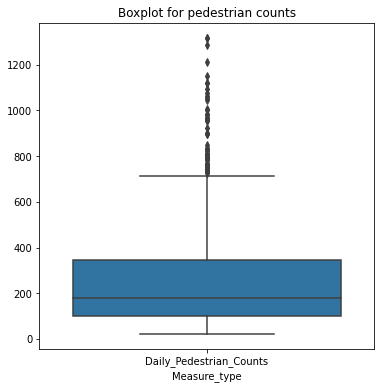

In [72]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.boxplot(data=df_avgDaily_readings[['Daily_Pedestrian_Counts']])
plt.title('Boxplot for pedestrian counts')
plt.show()

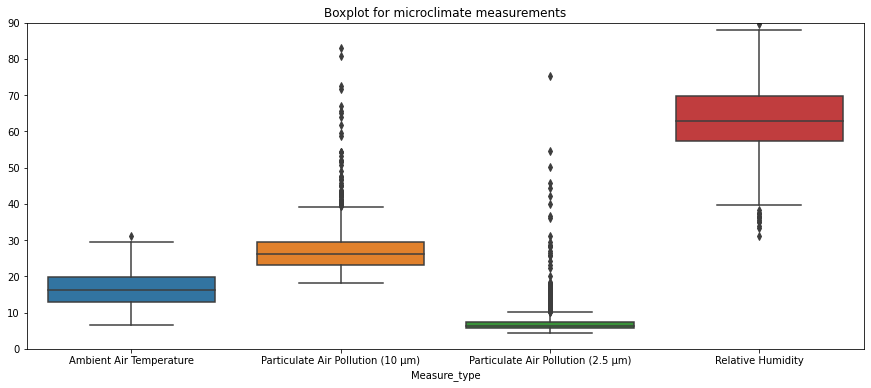

In [73]:
import seaborn as sns
plt.figure(figsize=(15,6))
sns.boxplot(data=df_avgDaily_readings[['Ambient Air Temperature','Particulate Air Pollution (10 µm)','Particulate Air Pollution (2.5 µm)','Relative Humidity']])
plt.ylim(0, 90)
plt.title('Boxplot for microclimate measurements')
plt.show()

The figure above shows a boxplot with the distribution of different microclimate readings. We are especially interested in the Particulate Air Pollution, for both 2.5 µm particles (PM2.5) and 10 µm particles (PM10). It seems that the median for small particles readings is around 10μg/m3, whereas for big particles is around 25μg/m3.

Let's also plot some scatter plots between all the features and some histograms for each feature:

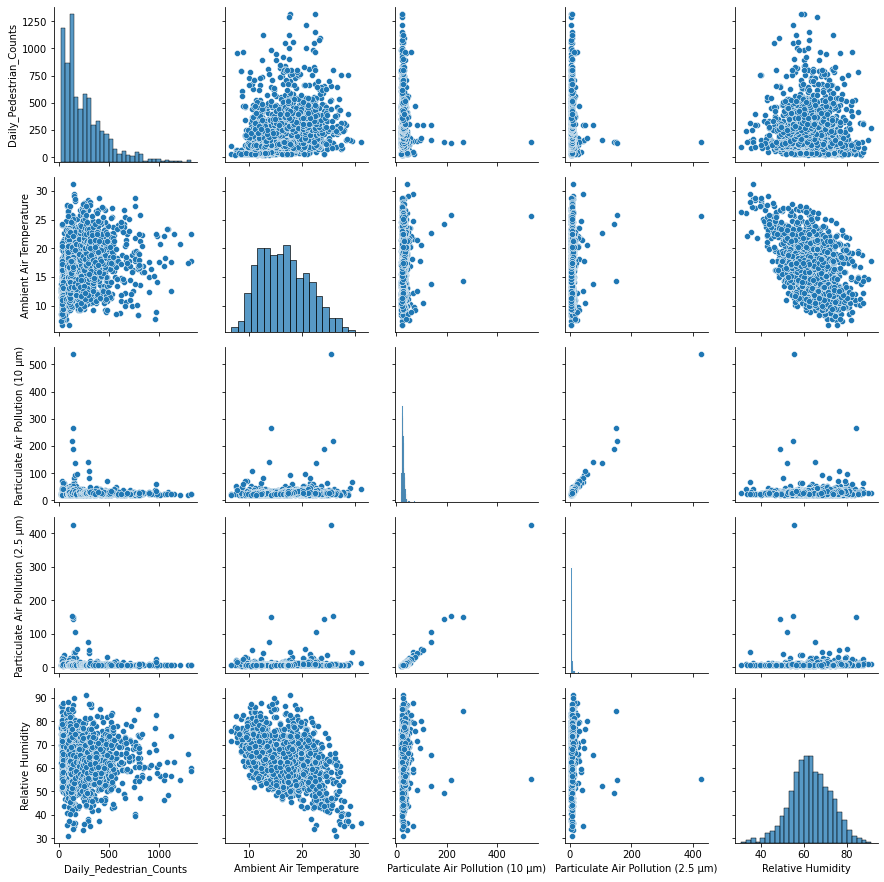

In [74]:

# plotting histograms and scatterplots
g = sns.PairGrid(df_avgDaily_readings)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

The plot above shows the scatter plots between all combinations of features, except between the same type of features. The diagonal plots show the histograms of each feature in order to find some information regarding the distribution of measurements. 

Ambient Air Temperature and Relative Humidity seem to be normally distributed. Furthermore, based on the scatterplots, there seems to be a strong positive correlation between Particulate Air Pollution (10 µm) and Particulate Air Pollution (2.5 µm). Furthermore, there seems to be a slightly negative correlation between Ambient Air Temperature and Relative Humidity. Let's plot a correlation matrix based on Pearson's coefficient (https://www.sciencedirect.com/topics/computer-science/pearson-correlation) to confirm:

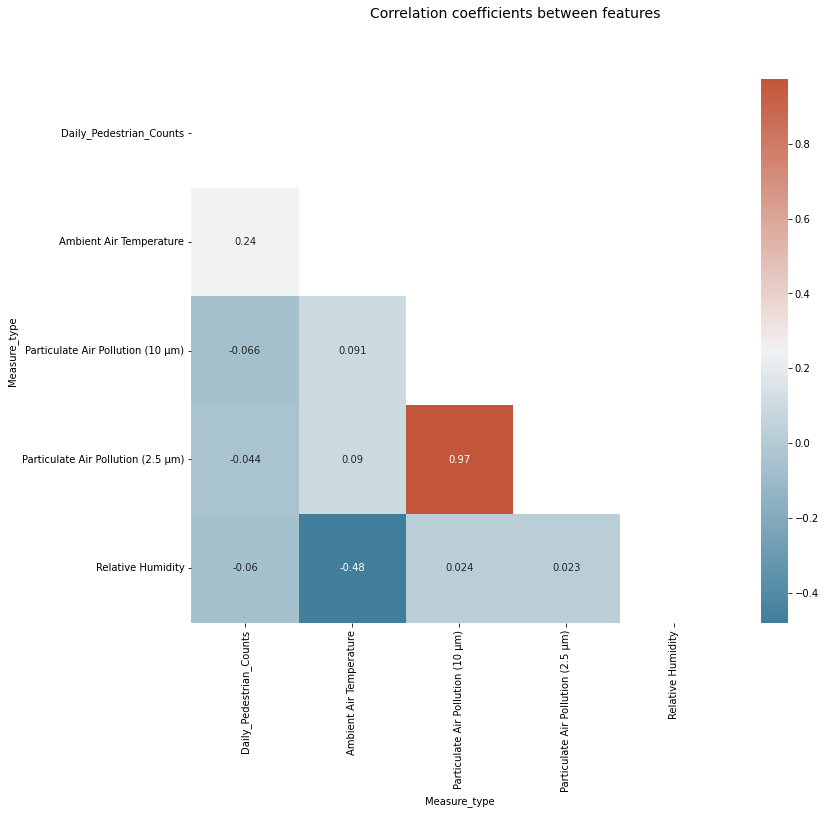

In [75]:
corr = df_avgDaily_readings.corr()
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))
plt.suptitle('Correlation coefficients between features', size = 14)
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.show()

The Coefficient Matrix confirms it: there is indeed a strong correlation between Particulate Air Pollution (10 µm) and Particulate Air Pollution (2.5 µm), as the Pearson's coefficient value of 0.97 shows. This is not surprising, as those are two indicators of air pollution which go hand in hand. Moreover, there is a slight negative correlation between Ambient Air Temperature and Relative Humidity (a coefficient of about -0.48), which could indicate that warm seasons are a bit dry in Melbourne.

# Modelling

For this modelling section, we would like to predict the air pollution based on:
* daily pedestrian counts
* daily microclimate readings: Ambient Air Temperature, Relative Humidity. 
* region
* date
       
The modelling is a classification task that will predict whether the air is polluted or not based on the mentioned features.The correlation matrix has shown that both types of Particulate Air Pollution (2.5 and 10 µm) go hand-in-hand. Thus, in order to decide whether the air is polluted or not, we will choose a threshold for both. 

According to this article: https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm10-particles-in-the-air, the quality of the air decreases when the big particle density (PM10) reaches a concentration above 40μg/m3. The boxplot shows that there are not so many values above this value, so we could choose a smaller threshold of 30μg/m3.

Previously we have already chosen a threshold for small air particles, but due to what the boxplot has shown, we need to lower the threshold. Thus, we can choose the following:
we will consider there is an unhealthy dose of air particles in the air when either there is a concentration of small Particulate Air Pollution (2.5 µm) above 8 μg/m3 *or* a concentration of big Particulate Air Pollution (10 µm) above 30 μg/m3.

Thus, we will create a new column: Moderate Air Pollution, which will have the value 1 if one of these thresholds has been breached or 0 otherwise:

In [76]:
ths_PM2_5 = 8
ths_PM10 = 28

conditions = [
    (df_avgDaily_readings['Particulate Air Pollution (2.5 µm)'] >= ths_PM2_5),
    (df_avgDaily_readings['Particulate Air Pollution (10 µm)'] >= ths_PM10),
    (df_avgDaily_readings['Particulate Air Pollution (2.5 µm)'] < ths_PM2_5),
    (df_avgDaily_readings['Particulate Air Pollution (10 µm)'] < ths_PM10)
]

# adding a new Region categorcal column
values = [1,1,0,0]

df_avgDaily_readings['Moderate_Air_Pollution'] = np.select(conditions, values)

df_avgDaily_readings['Moderate_Air_Pollution'].value_counts()

0    854
1    521
Name: Moderate_Air_Pollution, dtype: int64

The counts above show that there is still a class imbalance, although the thresholds are lowered. But we will try to model this dataset that we have. 

We also need to one-hot encode the region column:

In [77]:
# save a copy of the non-encoded data
df_avgDaily_readings_nonencoded = df_avgDaily_readings.copy()

# one-hot encoder for Region
df_avgDaily_readings = pd.get_dummies(df_avgDaily_readings, columns=['Region'], prefix=['Region'])
df_avgDaily_readings.drop(['Particulate Air Pollution (2.5 µm)', 'Particulate Air Pollution (10 µm)'], axis=1)
df_avgDaily_readings

,Date_day,Daily_Pedestrian_Counts,Ambient Air Temperature,Particulate Air Pollution (10 µm),Particulate Air Pollution (2.5 µm),Relative Humidity,Moderate_Air_Pollution,Region_Carlton,Region_Central,Region_Flinders,Region_SouthWarf
0,2019-11-15,198.220238,15.841067,27.861333,6.284000,57.491467,0,1,0,0,0
1,2019-11-16,183.910714,13.496833,32.911667,7.001667,58.615833,1,1,0,0,0
2,2019-11-17,250.565476,13.568500,28.391667,6.366667,59.040417,1,1,0,0,0
3,2019-11-18,184.184524,18.008750,25.415833,5.778333,51.026000,0,1,0,0,0
4,2019-11-19,178.267857,15.901500,28.940833,6.882500,66.653500,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1370,2022-03-30,424.379630,17.720625,26.650000,6.422917,57.741875,0,0,0,1,0
1371,2022-03-30,619.687500,17.276985,22.046542,4.991453,62.641615,0,0,0,0,1
1372,2022-03-31,394.839506,17.154062,30.775435,6.794783,60.253071,1,0,1,0,0
1373,2022-03-31,516.504630,17.354121,32.741403,7.117885,56.364644,1,0,0,1,0


We choose Moderate_Air_Pollution as y (what we try to predict) and the rest of the features as X (what we are making our prediction on). 

In [78]:
X = df_avgDaily_readings[['Daily_Pedestrian_Counts', 'Ambient Air Temperature',
                          'Relative Humidity','Region_Carlton', 'Region_Central',
                            'Region_Flinders', 'Region_SouthWarf']].to_numpy()
y = df_avgDaily_readings['Moderate_Air_Pollution'].to_numpy()

We split the data into testing and validation sets:

In [79]:
import sklearn
from sklearn.model_selection import train_test_split

# split with SKlearn
# make sure the split includes a balanced number of each class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True, stratify = y)

### Model 1: Decision Tree Classifier

Let's try to fit a simple decision tree classifier:

In [80]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# We predict the classes for both sets using the model we just fitted in order to evaluate error
y_est_test = clf.predict(X_test)
y_est_train = clf.predict(X_train)

# We valuate misclassification rate over train/test data (in this CV fold)
accuracy = np.sum(y_est_test == y_test) / float(len(y_est_test)) * 100
print('The accuracy is {}%'.format(int(accuracy)))

The accuracy is 61%


Let's try to optimize the tree in regards with the min_samples_split hyperparameter. We use a K-fold crossvalidation (K=10) for testing different values of the parameter while averaging the error on 10 different 10/90 split of the data. This will give us a good estimate of the value of the parameter that maximizes the accuracy of the model:

Computing CV fold: 1/10..
Computing CV fold: 2/10..
Computing CV fold: 3/10..
Computing CV fold: 4/10..
Computing CV fold: 5/10..
Computing CV fold: 6/10..
Computing CV fold: 7/10..
Computing CV fold: 8/10..
Computing CV fold: 9/10..
Computing CV fold: 10/10..


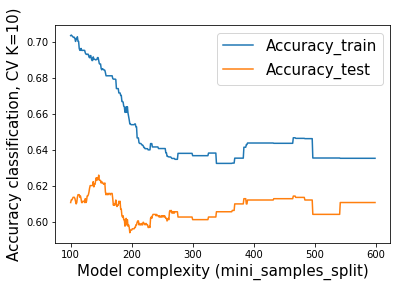

In [81]:
from sklearn import model_selection, tree
#Interval of values to be tested for mini_samples_split parameter. The interval was fine-tuned empirically.
ms_split = np.arange(100, 600, 1)

# K-fold crossvalidation, we choose a value of 10 which means we will split in 10 folds, nine will be used for 
#training and one of testing. We do this 10 times to use 10 different test splits and average the error.
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# We initialize arrays that will contain the training and testing errors for each value of the parameter and for
#each fold of the 10-fold.
Accuracy_train = np.empty((len(ms_split),K))
Accuracy_test = np.empty((len(ms_split),K))


k=0
#We loop in the different folds
for train_index, test_index in CV.split(X):
    print('Computing CV fold: {0}/{1}..'.format(k+1,K))
    
    #We extract training and test set for current CV fold
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    #We extract training and test sets for current CV fold
    for i, t in enumerate(ms_split):
        # We fit the decision tree classifier
        dtc = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=t,class_weight='balanced')
        dtc = dtc.fit(X_train,y_train.ravel())
    
        # We predict the classes for both sets using the model we just fitted in order to evaluate error
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        
        # We valuate misclassification rate over train/test data (in this CV fold)
        rightclass_rate_test = np.sum(y_est_test == y_test) / float(len(y_est_test))
        rightclass_rate_train = np.sum(y_est_train == y_train) / float(len(y_est_train))
        Accuracy_test[i,k], Accuracy_train[i,k] = rightclass_rate_test, rightclass_rate_train
        
    k+=1
    
 # We plot the average testing and training error for each value of the hyper parameter
plt.plot(ms_split, Accuracy_train.mean(1))
plt.plot(ms_split, Accuracy_test.mean(1))
plt.xlabel('Model complexity (mini_samples_split)', fontsize=15)
plt.ylabel('Accuracy classification, CV K={0})'.format(K), fontsize=15)
plt.legend(['Accuracy_train','Accuracy_test','TPR'], fontsize=15)
plt.show()

It seems that regardless of the splitting no of samples, the testing accuracy does not go above 62%. So using the tree we had before might be just as good.

Perhaps a single Decision Tree Classifier might not be the best approach... Let's try a Random Forrest Classifier, which is an ensemble of Decision trees. 
The code bellow also optimizes the parameters by performing a randomized search of the best parameters. Note that the parameters ranges have been adjusted after multiple trial and error runs. 

In [82]:
from sklearn.model_selection import RandomizedSearchCV
# Commented out due to randomness of changing values
'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 10)] # 5 samples between 100 and 400, evenly distributed
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(5, 14, num = 5)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [12, 3]
# Method of selecting samples for training each tree
bootstrap = [True]
'''
# Create the random grid
random_grid = {'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400],
               'max_features': ['sqrt'],
               'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None],
               'min_samples_split': [1, 8, 15, 22, 30],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True]}
print(random_grid)

{'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400], 'max_features': ['sqrt'], 'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None], 'min_samples_split': [1, 8, 15, 22, 30], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


In [83]:

import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier 
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [1, 2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 8, 15, 22, 30],
                                        'n_estimators': [100, 133, 166, 200,
                                                         233, 266, 300, 333,
                                                         366, 400]},
                   random_state=42, verbose=1)

In [84]:

print('The best Random Forrest Classifier hyperparameters are:')

The best Random Forrest Classifier hyperparameters are:


In [85]:
rf_random.best_params_

{'n_estimators': 133,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [86]:
# choose the best random forrest
rf_best = rf_random.best_estimator_

# save
# joblib.dump(rf, "./random_forest.joblib")

The combination from the experimented ranges of hyperparameters gave us an optimal random forrest classifier, which we have saved. 

In [87]:
# load the best random forest which has been saved
rf_best = joblib.load("./random_forest_best.joblib")
#predict
y_pred = rf_best.predict(X_test).T
ErrorRate = (y_test!=y_pred).sum(dtype=float)/len(y_test)
print('Error rate for the optimized Random forrest: {:.2f}%'.format(ErrorRate*100))    
print('Accuracy for the optimized Random forrest: {:.2f}%'.format((1-ErrorRate)*100))

Error rate for the optimized Random forrest: 13.87%
Accuracy for the optimized Random forrest: 86.13%


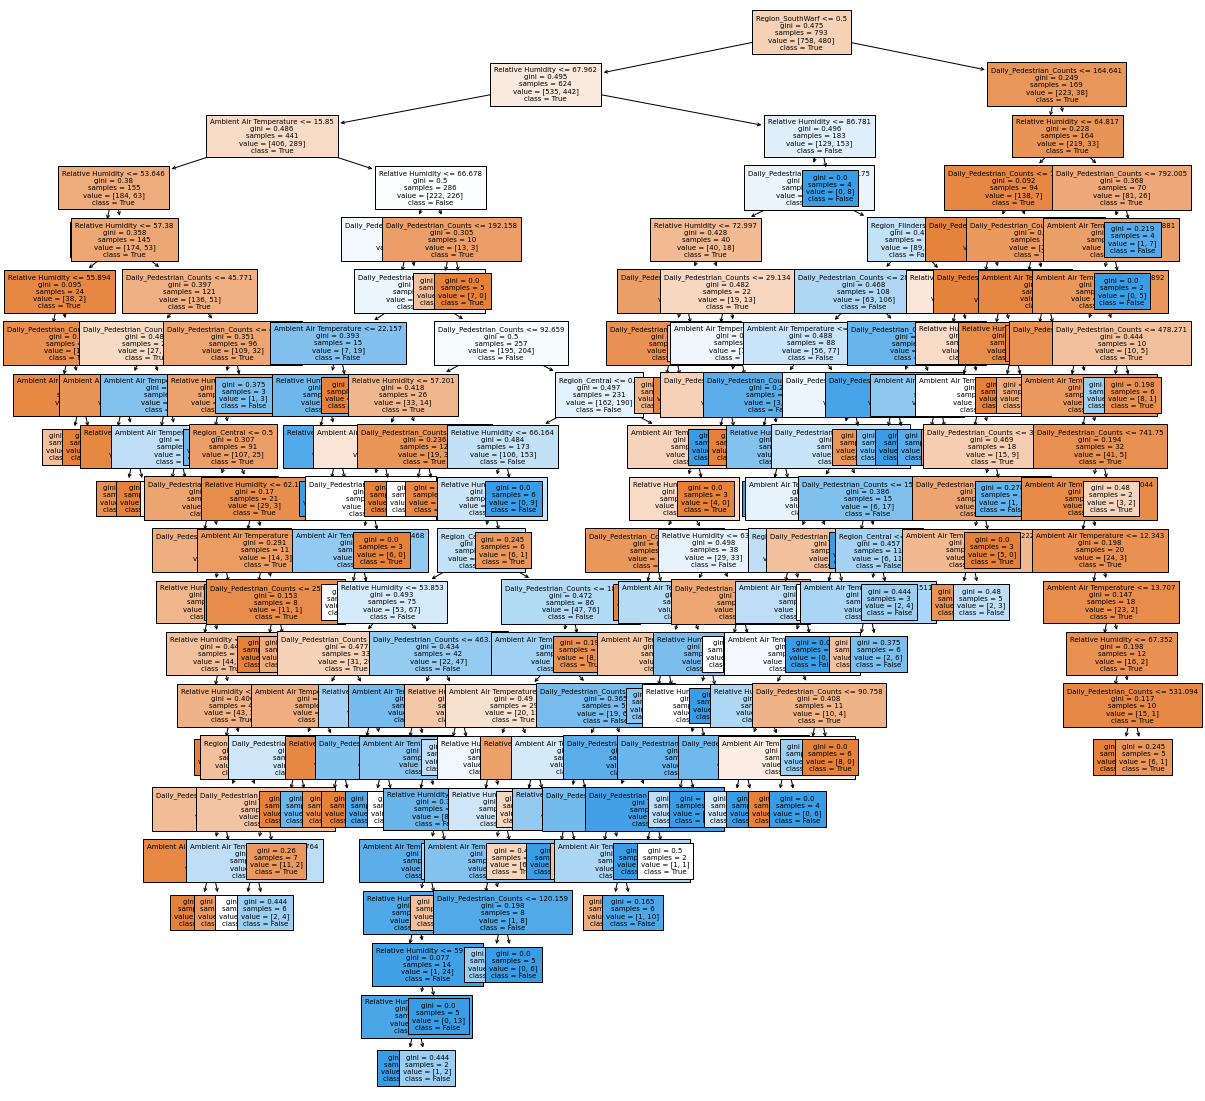

In [88]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
#One decision tree plotted of the ensemble forrest:
X_df = df_avgDaily_readings[['Daily_Pedestrian_Counts', 'Ambient Air Temperature',
                          'Relative Humidity','Region_Carlton', 'Region_Central',
                            'Region_Flinders', 'Region_SouthWarf']]
feature_names = X_df.columns.tolist()
target_names = ['True','False']


plt.figure(figsize=(20,20)) 
tree.plot_tree(rf_best.estimators_[0], feature_names=feature_names, class_names=target_names, fontsize=7, filled=True)
plt.savefig('dtc.pdf')

plt.show()



The samples are split based on the dataframe features. We can see that the branches get more pure  towards the bottom. 

### Model 2: Logistic Regression
Let's also try a Logistic Regression model to classify air pollution:

In [89]:
from sklearn.linear_model import LogisticRegression

# logistic_regression
# default solver is incredibly slow thats why we change it
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=10000)
logisticRegr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Let's have a look at the accuracy and F1 score of our model:

In [90]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predictions = logisticRegr.predict(X_test)
#calculate F1 score
f1_s = f1_score(y_test, predictions)
acc = accuracy_score(y_test, predictions)*100

print("The Logistic Regression model we have used to predict the air pollution has an accuracy of {:2.1f}% and an F1 score of {:.2f}".format(acc,f1_s))

The Logistic Regression model we have used to predict the air pollution has an accuracy of 62.8% and an F1 score of 0.41


This means that the best model for predicting whether there is moderate air pollution or not based on other microclimate factors and pedestrian counts is a Random Forrest Classifier.

## Inspecting Model bias

Although the model is good at predicting, we are aware that in some areas, there are fewer readings or the pollution is higher due to the fact that the sensors are installed in areas where there are more cars - hence might be more traffic. Unfortunately, our model does not take traffic into consideration, since we could not find a representative traffic dataset for Melbourne in that area for the exact dates (2019-2022) to train it with. Hence, we can take into account the 'Region' for debiasing our model. 

First, let's do an interractive Bokeh bar count to check the average air pollution reading occurences based on each region:

In [91]:
# group the data
dfra=df_avgDaily_readings_nonencoded.groupby(['Region']).size().reset_index(name='samples_by_region')
df_region=df_avgDaily_readings_nonencoded.groupby(['Region'])['Moderate_Air_Pollution'].apply(lambda x: (x==1).sum()).reset_index(name='re_com')

# for legend
df_region = df_region.join(dfra, rsuffix='_caller')
df_region = df_region.drop(['Region_caller'],axis=1)
df_region['frac_air_pollution'] = df_region['re_com']/df_region['samples_by_region']
df_region['frac_total'] = df_region['re_com']/df_region['re_com'].sum()

# rename column values
dict = {"SouthWarf" : 'South Wharf', "Flinders" : 'Flinders Crossroad', "Central": 'Central Area', "Carlton" : 'Carlton'}
df_region=df_region.replace({"Region": dict})

In [92]:

#Convert your DataFrame to Bokeh ColumnDataSource
src = ColumnDataSource(df_region)


region_label = ['South Wharf','Flinders Crossroad','Central Area','Carlton']

#Create an empty figure
fig3 = figure(x_range=region_label, plot_width = 800, plot_height = 500, title = 'Number of Samples by Region',
           x_axis_label = 'Region', y_axis_label = 'Number of Samples') 

#Define the columns to use for each bar
color = ['lightsalmon','maroon']
bar_cols = ['samples_by_region', 're_com']

#labels for legend
legend_labels = ['Samples by Region', 'Moderate Air Pollution Readings']
pattern=[' ', '/']
patcol= ['black', 'black']
fill = [1, 0]


#Create empty list for custom legend
items = []
#Add bars by using p.var
bar = {} 
for indx, i in enumerate(bar_cols):
    bar[i] = fig3.vbar(x='Region',  top=i, source=src, width=0.5,color=color[indx], legend_label=i, fill_alpha=fill[indx], hatch_pattern=pattern[indx], hatch_color=patcol[indx])
    items.append((legend_labels[indx], [bar[i]]))

#This is to manage the legend in plot
fig3.legend.visible = False

#add the legend outside the plot
legend = Legend(items=items)
fig3.add_layout(legend, 'left')
fig3.legend.click_policy = "hide" 
    

fig3.add_tools(HoverTool(
    tooltips=[
        ('Fraction of moderate air pollution occurences by region: ', '@frac_recid{%0.2f}'),
        ('Fraction of total moderate air pollution occurences by region: ', '@frac_total{%0.2f}')
    ],
    renderers=[bar[i]]
  
))

In [93]:
# Bokeh plotting
l3 = layout([[fig3]])

tab3 = Panel(child=l3,title="Show by Race")
tabs = Tabs(tabs=[ tab3 ])

curdoc().add_root(tabs)
output_notebook()
show(tabs)

Loading BokehJS ...

One can see that there are a lot of readings in the Carlton region, where most readings of mild air pollution occur. Another thing to notice is the area in South Wharf, which is under-represented. Not a lot of mild air pollution readings occur there.

We can try to further inspect the model classification results by taking a closer look in those areas. 

In [94]:
col_carlton = -5
col_central = -4
col_flinders = -3    
col_SouthWarf = -2   

# append y_test to X_test
ytst = np.array([y_test]).reshape(-1,1)
X_test_y = np.concatenate((X_test,ytst),axis=1)

regions = ['South Wharf','Flinders Crossroad','Central Melbourne','Carlton']
X_tests = []
y_tests = []


# filter test set per region:

x_test_SouthWarf = X_test_y[np.logical_not(X_test_y[:,col_SouthWarf] == 0)]
y_test_SouthWarf =  x_test_SouthWarf[:,-1]
x_test_SouthWarf = x_test_SouthWarf[:,:-1]
X_tests.append(x_test_SouthWarf)
y_tests.append(y_test_SouthWarf)

x_test_flinders = X_test_y[np.logical_not(X_test_y[:,col_flinders] == 0)]
y_test_flinders =  x_test_flinders[:,-1]
x_test_flinders = x_test_flinders[:,:-1]
X_tests.append(x_test_flinders)
y_tests.append(y_test_flinders)

x_test_central = X_test_y[np.logical_not(X_test_y[:,col_central] == 0)]
y_test_central =  x_test_central[:,-1]
x_test_central = x_test_central[:,:-1]
X_tests.append(x_test_central)
y_tests.append(y_test_central)


x_test_carlton = X_test_y[np.logical_not(X_test_y[:,col_carlton] == 0)]
y_test_carlton =  x_test_carlton[:,-1]
x_test_carlton = x_test_carlton[:,:-1]
X_tests.append(x_test_carlton)
y_tests.append(y_test_carlton)

## Classification Results
- feature importance
- confusion matrix for the whole model
- percentage difference of the confusion matrix
- confusion matrices per region-area
- ROC curves

In [95]:

y_est_test = rf_best.predict(X_test)
y_est_train = rf_best.predict(X_train)

y_pred_southwharf = rf_best.predict(X_tests[0])
y_pred_carlton = rf_best.predict(X_tests[3])

#Create a list of features that the model uses in order to predic reviced crime.
feature_list = rf_best.feature_importances_
#Create list of feature names

feature_titles = ['Daily_Pedestrian_Counts', 'Ambient Air Temperature',
                          'Relative Humidity','Region_Carlton', 'Region_Central',
                            'Region_Flinders', 'Region_SouthWarf']

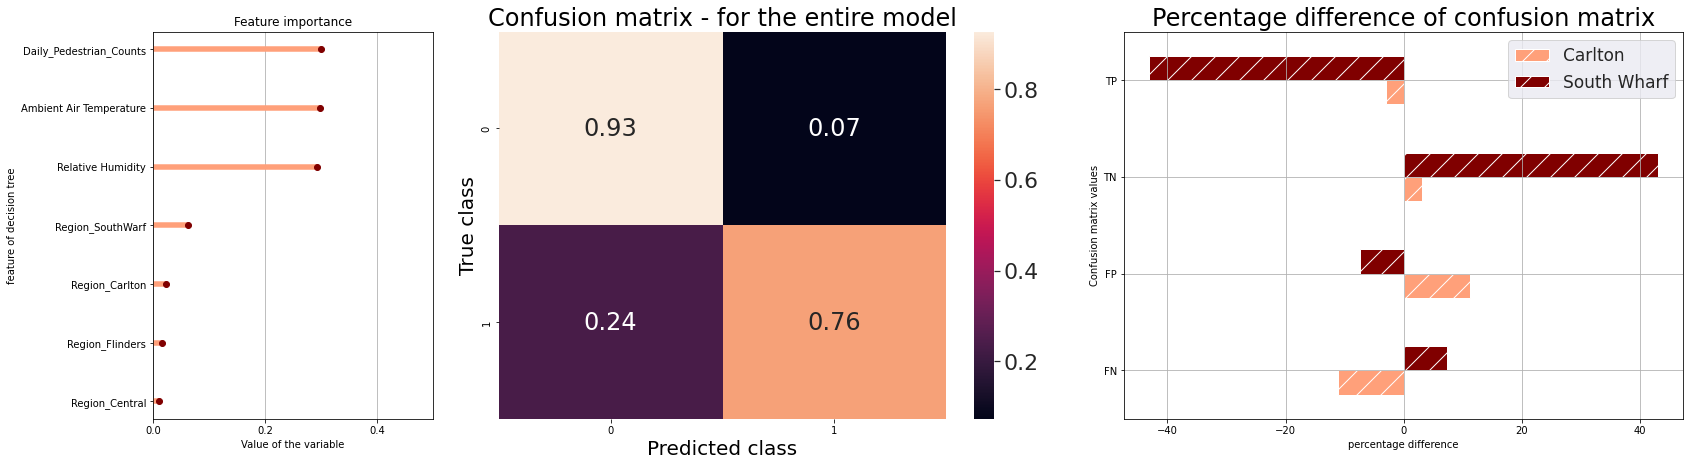

In [96]:
from sklearn import metrics
# Create a dataframe of features for lollipop plot
df_ft = pd.DataFrame({'group':feature_titles, 'values':feature_list})
 
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [5, 10, 10]},figsize=(24, 7))
# Reorder it based on the values
ordered_df = df_ft.sort_values(by='values')
my_range=range(1,len(df_ft.index)+1)
 
# The horizontal plot is made using the hline function
ax1.hlines(y=my_range, xmin=0, xmax=ordered_df['values'], color='lightsalmon', linestyles='solid',linewidths=5.5)
ax1.plot(ordered_df['values'], my_range, "o", color='maroon')
 
# Add titles and axis names
ax1.set_yticks(my_range)
ax1.set_yticklabels(ordered_df['group'])
ax1.set_title("Feature importance", loc='center')
ax1.set_xlabel('Value of the variable')
ax1.set_ylabel('feature of decision tree')
ax1.xaxis.grid()
ax1.set_xlim([0,0.5])

# Make second plot for figure
# Confusion matrix plot for the entire model 
cm_tot = metrics.confusion_matrix(y_test, y_est_test, normalize='true')
sns.set(font_scale=2)
f = sns.heatmap(cm_tot, annot=True, fmt='.2f', ax=ax2)
f.set_xlabel("Predicted class", fontsize = 20)
f.set_ylabel("True class", fontsize = 20)
f.set(title='Confusion matrix - for the entire model')

# Get values from confusion matrix for both caucasian and african-american
cm_c = metrics.confusion_matrix(y_test_carlton, y_pred_carlton, normalize='true')
cm_aa = metrics.confusion_matrix(y_test_SouthWarf, y_pred_southwharf, normalize='true')

#Calculate the difference to the model
d_ca = cm_c-cm_tot
d_aa = cm_aa-cm_tot

#flatten 2d array to 1d array
d_ca = d_ca.flatten()
d_aa = d_aa.flatten()

#make third plot
carlton = d_ca*100
south_w = d_aa*100
data = {'Carlton': carlton, 'South Wharf': south_w}
df = pd.DataFrame(data,columns=['Carlton','South Wharf'], index = ['FN','FP','TN','TP'])

#add the horizontalbar plot to the subplot
df.plot.barh(color=['lightsalmon','maroon'], ax=ax3, hatch='/').legend(loc='upper left')
plt.title('Percentage difference of confusion matrix')
plt.ylabel('Confusion matrix values')
plt.xlabel('percentage difference')
plt.legend(loc='upper right', fontsize=17)

fig.tight_layout()
# Show the plot
plt.show()

There is definitely a percentage difference between the areas in Carlton and South Wharf, but the percentage differences between the False Positives and True Negatives rates are not that significant.

The plot to the left is the Feature Importance plot, which shows the importance of each feature in our model. It looks like the Daily Pedestrian (average) Counts has an important influence for predicting moderate air pollution, and so do the ambient air temperature and humidity. The temperature factor was expected, since arid weather is usually loosening more dust into the air. Humidity is also explainable: when it is higher humidity there is more deposition of particulate matter in the air . However, we found something interesting: air pollution is also affected by the number of pedestrians in a given location.

The plot in the middle shows a Confusion Matrix of our total predictions. Our model has predicted 76% of the true positives and 93% of the true negatives, which is a good sign. Overall, we have very low numeber of false positives (FP), but about 24% of the actual negative classes were not predicted. This means that our model sometimes asseses wrongly when there is a moderate a moderate air pollution in a given local area.

The plot in the right shows percentage difference. Since we have seen an imbalance with the areas in Carlton and South Wharf, we have tried to compare the percentage differences between those based on their confusion matrices values. There is a big percentage difference of TP and TN, but not that big of a difference the FP and the FN. We are more interested in the latter difference, since this would have shown if the model misclassifies differently based on a specific area. It might do so slightly, but the percentage difference is not that much.

### Different classification threshold
Let's say we want our model to say there is a moderate air pollution only when it is 80% certain of it. Let's calculate the accuracy and plot a confusion matrix.

In [97]:
threshold = 0.8
y_pred_highths = (rf_best.predict_proba(X_test)[:, 1] > threshold).astype('float')
accuracy = np.sum(y_pred_highths == y_test) / float(len(y_test)) * 100
print('The accuracy of a model with 80% confidence as threshold is {}%'.format(int(accuracy)))

The accuracy of a model with 80% confidence as threshold is 64%


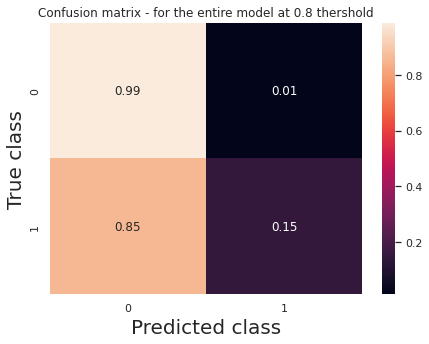

In [98]:

from sklearn import metrics
# Confusion matrix plot for the entire model 
cm_tot = metrics.confusion_matrix(y_test, y_pred_highths, normalize='true')
plt.figure(figsize=(7,5))
sns.set(font_scale=1)
sns.heatmap(cm_tot, annot=True, fmt='.2f')
plt.xlabel("Predicted class", fontsize = 20)
plt.ylabel("True class", fontsize = 20)
plt.title(label='Confusion matrix - for the entire model at 0.8 thershold')
plt.show()

Our model performs worse, since the accuracy decreased and the amount of false negatives increased. This is somewhat interesting, as for each model, the more certain you want it to be, the slightly worse it will perform. So for now, let's stick to the 50% threshold! The 0.5 threshold separation gives actually better results. It is a trade-off we are willing to accept.  

## Confusion matrix for each region

Let's now plot the confusion matrices for each region the area-samples were taken from:

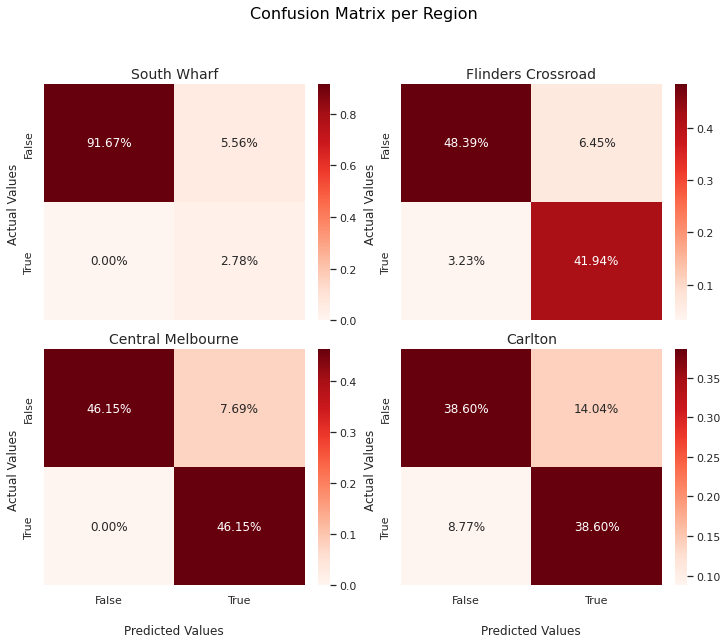

In [99]:
# setting the subplots and overall title
fig, ax = plt.subplots(2, 2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Confusion Matrix per Region', size = 16, color = 'black', y=1.10)
sns.set(font_scale=1)
i_x = 0
i_y = 0

for i in range(4):
    #Generate the confusion matrix for each Region
    predictions = rf_best.predict(X_tests[i])
    cf_matrix = confusion_matrix(predictions, y_tests[i])

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds',  ax=ax[i_x, i_y])

    ax[i_x,i_y].set_xlabel('\nPredicted Values', fontsize = 12)
    ax[i_x,i_y].set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax[i_x,i_y].xaxis.set_ticklabels(['False','True'])
    ax[i_x,i_y].yaxis.set_ticklabels(['False','True'])

    ax[i_x,i_y].set_title(regions[i], size = 14)
    ax[i_x,i_y].axes.get_xaxis().set_visible(False)
    ax[1,0].axes.get_xaxis().set_visible(True)
    ax[1,1].axes.get_xaxis().set_visible(True)
    i_y +=1
    
    #fig.tight_layout()

    # reset subplot axes
    if i_y > 1:
        i_x +=1
        i_y =0 
plt.savefig('confusion_matrices_per_region.png', bbox_inches='tight')

One can see from the confusion matrices that the model was quite good at presdicting most of the percentegase of true positives and false negatives, for every reagion-area. There are more samples and more frequent mild air pollution values recorded in Carlton than in South Wharf, and this is reflexted in the confusion matrix for Carlton. The model predicted overall a lower percentage of true positives and true negatives, which means that the model is not as good at distunguishing between classes in the Carlton area (that is, predicting whether there is mild air pollution or not).
 
Including the observations for the confusion matrices plotted for each region, we have concluded that our model does not need debiasing, although the model performs a bit poorer when it comes to the area in Carlton.

## ROC Curves with Bokeh

Let us plot the ROC curves of each region areas given a range of thrersholds:

In [100]:
ths = np.linspace(1e-5,1-1e-5, 15)


def y_hat_cal(y_prob, th):
    """
    Function for calling y_hat_map for an array of probabilities 
    """
    y_hat = []
    for i in range(len(y_prob)):
        if y_prob[i][1] > th:
            y_hat.append(1)
        else:
            y_hat.append(0)
    return(np.array(y_hat))

def tpr_fpr(y, y_hat):
    
    fp = np.sum((y_hat == 1) & (y == 0))
    tp = np.sum((y_hat == 1) & (y == 1))

    fn = np.sum((y_hat == 0) & (y == 1))
    tn = np.sum((y_hat == 0) & (y == 0))
    
    fpr = (fp / (fp + tn))
    tpr = (tp / (tp + fn))
    
    return(fpr,tpr)

#This function takes as an input y, y_probs, thr 
#and returns the points to plot the ROC curve and their threshold
def roc_curve(y, y_probs, ths):
#initialize roc as an empty np.array
    roc = np.array([])
#loop over thresholds
    for th in ths:
        #convert y_prob in y_hat
        y_hat = y_hat_cal(y_probs,th)
        #compute TPR and FPR
        FPR, TPR = tpr_fpr(y, y_hat)
        #add threshold and point to roc array
        roc = np.append(roc, [th, FPR, TPR])
        #return roc
    return roc.reshape(-1, 3)

In [101]:
y_prob_southwharf = rf_best.predict_proba(X_tests[0])
y_test_southwharf = y_tests[0]

y_prob_flinders = rf_best.predict_proba(X_tests[1])
y_test_flinders = y_tests[1]

y_prob_central = rf_best.predict_proba(X_tests[2])
y_test_central = y_tests[2]

y_prob_carlton = rf_best.predict_proba(X_tests[3])
y_test_carlton = y_tests[3]

#We compute the ROC curves for both areas using the defined thresholds
roc_southwharf = roc_curve(y_test_southwharf, y_prob_southwharf, ths)
roc_flinders = roc_curve(y_test_flinders, y_prob_flinders, ths)
roc_central = roc_curve(y_test_central, y_prob_central, ths)
roc_carlton = roc_curve(y_test_carlton, y_prob_carlton, ths)

In [102]:
#We create a dataframe that will contain the different values of FPR and TPR to plot with Bokeh
df_roc = pd.DataFrame()  

df_roc['FPR_SW'] = roc_southwharf[:,1]
df_roc['TPR_SW'] = roc_southwharf[:,2]
df_roc['FPR_FL'] = roc_flinders[:,1]
df_roc['TPR_FL'] = roc_flinders[:,2]
df_roc['FPR_CE'] = roc_central[:,1]
df_roc['TPR_CE'] = roc_central[:,2]
df_roc['FPR_CA'] = roc_carlton[:,1]
df_roc['TPR_CA'] = roc_carlton[:,2]

#We create another dataframe to associate each point of the ROC curves with a value th to have a hover feature
#that will allow us to know what th corresponds to each point
df_tresholds = pd.DataFrame()  
df_tresholds['x'] =np.concatenate((df_roc['FPR_SW'], df_roc['FPR_FL'],df_roc['FPR_CE'],df_roc['FPR_CA']))
df_tresholds['y'] =np.concatenate((df_roc['TPR_SW'], df_roc['TPR_FL'],df_roc['TPR_CE'],df_roc['TPR_CA']))
df_tresholds['th'] =np.concatenate((ths, ths, ths, ths))

#We convert the dataframes into ColumnDataSource for input to a Bokeh figure
output_notebook()
source = ColumnDataSource(df_roc)
source2 = ColumnDataSource(df_tresholds)

#Here we plot two ROC lines for each population
p = figure(title="AUC ROC", x_axis_label='FPR', y_axis_label='TPR', 
                   plot_width=700, plot_height=400)
p.xaxis.axis_label = "FPR"
p.yaxis.axis_label = "TPR"

p.line(x='FPR_SW',y='TPR_SW', source=source, legend_label="South Wharf", line_color="#FFC107", line_width=2)
p.line(x='FPR_FL',y='TPR_FL', source=source, legend_label="Flinders Street", line_color="cyan", line_width=2)
p.line(x='FPR_CE',y='TPR_CE', source=source, legend_label="Central Area", line_color="pink", line_width=2)
p.line(x='FPR_CA',y='TPR_CA', source=source, legend_label="Carlton", line_color="#D81B60", line_width=2)

#Here we add for each point a circle annotation with the th reference when hovering
cr = p.circle('x','y',source=source2, line_color="blue", fill_color="blue")
p.add_tools(HoverTool(tooltips=[('Threshold', '@th')], renderers=[cr]))

show(p)

Loading BokehJS ...

The ROC curve has a different shape when it comes for the area selected in the Carlton region. The area under the curve indicates how good the model each at making classifications for each region. The area under curve seems smaller for Carlton, and it is no surprise as it contains more false negatives. It is expected that the model misclassifies more since there are more samples and less chance for overfitting (the model makes more mistakes). 

However, let us still try to de-bias our model based on the region, to see if it brings any value. Based on the ROC curve, we selected the point on the ROC curve for Carlton, which is closest to the ROC curves for the other regions. We have selected thus the point at threshold = 0.615.

In [103]:
#Here we try to debias the prediction using the y_prob for each population and the treshold found above for the Carlton region
th = 0.615
for i in range(len(y_prob_carlton)):
    if y_prob_carlton[i,1] > th:
        y_pred_carlton[i] = 1
    else:
        y_pred_carlton[i] = 0

#Calculating new values for TPR and FPR       
FPR_AA_AF, TPR_AA_AF = tpr_fpr(y_test_carlton, y_pred_carlton)

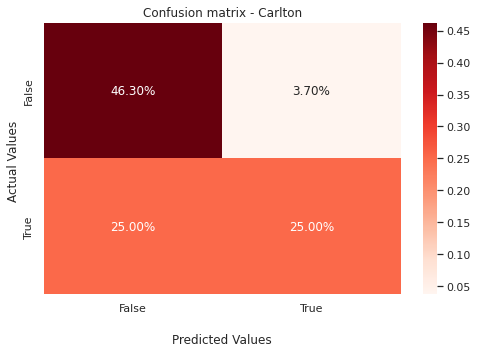

In [104]:
#For african-american with normalization to have a value between 0 and 1
fig=plt.figure(figsize=(8,5))

cm = metrics.confusion_matrix(y_test_carlton, y_pred_carlton, normalize='true')
f = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Reds')

f.set_xlabel('\nPredicted Values')
f.set_ylabel('Actual Values ')
f.set(title='Confusion matrix - Carlton')
## Ticket labels - List must be in alphabetical order
f.xaxis.set_ticklabels(['False','True'])
f.yaxis.set_ticklabels(['False','True'])
plt.show()

While the amount of false positives has decreased, the amount of false negatives has increased. Hence the debiasing method is giving a bad trade-off for the model classification. 

## Contributions 
(we used the ids given from Assignment 2)

#### ST202

Notebook

    - Microclimate temporal patterns

    - Microclimate temporal development

Website

    - Website Design
    
    - Website posts: Homepage, Analysis tab: Temporal Patterns and Development, GeoData, Key Takeaways

#### ST64

Notebook

    - Merging Datasets 
    
    - Modelling ST64

    - Data Exploration ST64

Website
    
    - Website posts: Project tab, Analysis tab:  Merging the Datasets, Exploratory Analysis, Modelling
